In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
import numpy as np
np.__version__

'1.24.4'

## Load data & parameters

In [3]:
Smillie_marker      = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Smillie_et_al/colon_epithelial_marker.csv')
CellCycle_marker    = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/cell_cycle/cell_cycle_marker.tsv', sep='\t')
G2M_markers = list(CellCycle_marker[(CellCycle_marker['phase']=='G2/M')]['gene_symbol'])
S_markers   = list(CellCycle_marker[(CellCycle_marker['phase']=='S')]['gene_symbol'])

In [4]:
adata_epi_chen      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')
adata_epi_joanito   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

In [ ]:
with plt.rc_context({"figure.dpi": (300)}):
    sc.pl.umap(adata_epi_joanito, color=['PatientID'], title='')

In [5]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_epi_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_epi_chen.obs['PatientID'] ]

In [6]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'SC035', 'CRC2783', 'SC044']

In [6]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity)) & 
                                      (adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_joanito_tumor = adata_epi_joanito[(adata_epi_joanito.obs['PatientID'].isin(joanito_patient_order_by_MSI_intensity)) & 
                                            (adata_epi_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()

In [7]:
adata_epi_chen_tumor = adata_epi_chen_tumor.raw.to_adata()
sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)

adata_epi_joanito_tumor = adata_epi_joanito_tumor.raw.to_adata()
sc.pp.normalize_total(adata_epi_joanito_tumor)
sc.pp.log1p(adata_epi_joanito_tumor)

In [8]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epi_joanito_tumor.var["mt"] = adata_epi_joanito_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_epi_joanito_tumor.var["ribo"] = adata_epi_joanito_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epi_joanito_tumor.var["hb"] = adata_epi_joanito_tumor.var_names.str.contains("^HB[^(P)]")

adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.mt==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.ribo==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.hb==False].copy()

In [9]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epi_chen_tumor.var["mt"] = adata_epi_chen_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_epi_chen_tumor.var["ribo"] = adata_epi_chen_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epi_chen_tumor.var["hb"] = adata_epi_chen_tumor.var_names.str.contains("^HB[^(P)]")

adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.mt==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.ribo==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.hb==False].copy()

## Inter-patient comparison: Low vs. High

In [ ]:
# ### Include all genes (MT-, RPS-, RPL-, HB-)

In [49]:
 #! Exclude MT/Ribo/Hb genes (MT-, RPS-, RPL-, HB-)

### Identify MSI-L/H-associated genes, recurrent in both dataset

#### Preprocess adatas

In [10]:
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor.copy()
sc.pp.filter_genes(adata_epi_joanito_tumor_copy, min_counts=500)
adata_epi_chen_tumor_copy = adata_epi_chen_tumor.copy()
sc.pp.filter_genes(adata_epi_chen_tumor_copy, min_counts=500)

adata_epi_joanito_tumor_copy.shape[1], adata_epi_chen_tumor_copy.shape[1]

(9012, 9370)

In [11]:
adata_epi_joanito_tumor_copy.var["mt"] = adata_epi_joanito_tumor_copy.var_names.str.startswith("MT-")
adata_epi_joanito_tumor_copy.var["ribo"] = adata_epi_joanito_tumor_copy.var_names.str.startswith(("RPS", "RPL"))
adata_epi_joanito_tumor_copy.var["hb"] = adata_epi_joanito_tumor_copy.var_names.str.contains("^HB[^(P)]")

adata_epi_chen_tumor_copy.var["mt"] = adata_epi_chen_tumor_copy.var_names.str.startswith("MT-")
adata_epi_chen_tumor_copy.var["ribo"] = adata_epi_chen_tumor_copy.var_names.str.startswith(("RPS", "RPL"))
adata_epi_chen_tumor_copy.var["hb"] = adata_epi_chen_tumor_copy.var_names.str.contains("^HB[^(P)]")

adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor_copy[:, adata_epi_joanito_tumor_copy.var.mt==False].copy()
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor_copy[:, adata_epi_joanito_tumor_copy.var.ribo==False].copy()
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor_copy[:, adata_epi_joanito_tumor_copy.var.hb==False].copy()

adata_epi_chen_tumor_copy = adata_epi_chen_tumor_copy[:, adata_epi_chen_tumor_copy.var.mt==False].copy()
adata_epi_chen_tumor_copy = adata_epi_chen_tumor_copy[:, adata_epi_chen_tumor_copy.var.ribo==False].copy()
adata_epi_chen_tumor_copy = adata_epi_chen_tumor_copy[:, adata_epi_chen_tumor_copy.var.hb==False].copy()

In [12]:
dict_PatientID_to_AvgAvgSTRDiff = { PatientID : np.mean(edf['AvgSTRDiff']) for PatientID, edf in adata_epi_joanito_tumor_copy.obs.groupby('PatientID', observed=True,) }
dict_PatientID_to_MSIintensityClass = { 'SC044' : 'High', 'SC035' : 'Mid', 'CRC2783' : 'Mid', 'CRC2817' : 'Low' }
adata_epi_joanito_tumor_copy.obs['MSI_class'] = [ dict_PatientID_to_MSIintensityClass[PatientID] for PatientID in adata_epi_joanito_tumor_copy.obs['PatientID'] ]
adata_epi_joanito_tumor_copy.obs['MSI_class'] = adata_epi_joanito_tumor_copy.obs['MSI_class'].astype('category')
adata_epi_joanito_tumor_copy.obs['MSI_class'] = adata_epi_joanito_tumor_copy.obs['MSI_class'].cat.reorder_categories(['Low', 'Mid', 'High'])
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor_copy[adata_epi_joanito_tumor_copy.obs['MSI_class']!='Mid'].copy()
adata_epi_joanito_tumor_copy.shape[0]

1700

In [13]:
dict_PatientID_to_AvgAvgSTRDiff = { PatientID : np.mean(edf['AvgSTRDiff']) for PatientID, edf in adata_epi_chen_tumor_copy.obs.groupby('PatientID', observed=True,) }
dict_PatientID_to_AvgAvgSTRDiff = dict(sorted(dict_PatientID_to_AvgAvgSTRDiff.items(), key=lambda x:x[1]))
dict_PatientID_to_MSIintensityClass = { 'P04' : 'High', 
                                       'P21' : 'High', 
                                       'P23' : 'High', 
                                       'P22' : 'High', 
                                       'P19' : 'Mid', 
                                       'P20' : 'Mid', 
                                       'P26' : 'Mid', 
                                       'P15' : 'Mid', 
                                       'P17' : 'Low', 
                                       'P18' : 'Low',
                                       }
adata_epi_chen_tumor_copy.obs['MSI_class'] = [ dict_PatientID_to_MSIintensityClass[PatientID] for PatientID in adata_epi_chen_tumor_copy.obs['PatientID'] ]
adata_epi_chen_tumor_copy.obs['MSI_class'] = adata_epi_chen_tumor_copy.obs['MSI_class'].astype('category')
adata_epi_chen_tumor_copy.obs['MSI_class'] = adata_epi_chen_tumor_copy.obs['MSI_class'].cat.reorder_categories(['Low', 'Mid', 'High'])
adata_epi_chen_tumor_copy = adata_epi_chen_tumor_copy[adata_epi_chen_tumor_copy.obs['MSI_class']!='Mid'].copy()
adata_epi_chen_tumor_copy.shape[0]

9215

#### Rank genes

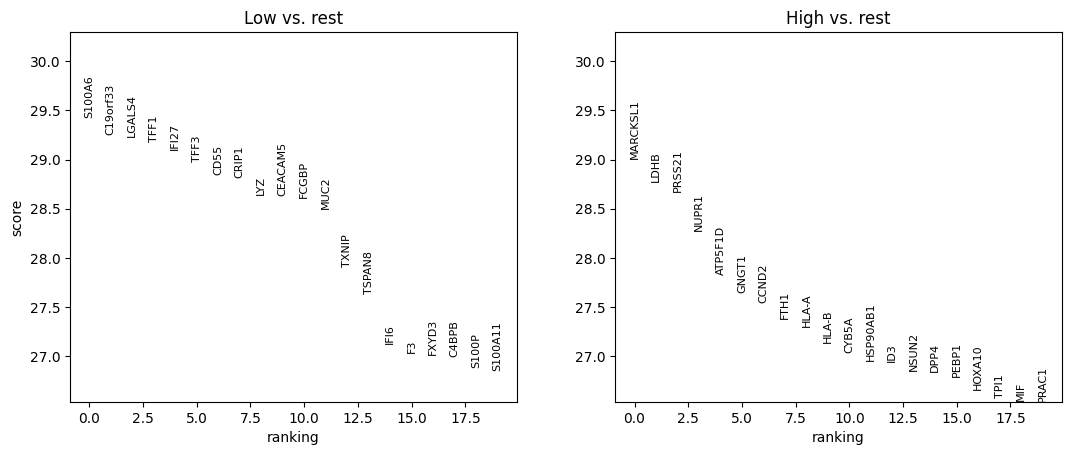

In [14]:
sc.tl.rank_genes_groups(adata_epi_joanito_tumor_copy, groupby='MSI_class', method='wilcoxon')
sc.pl.rank_genes_groups(adata_epi_joanito_tumor_copy, groupby='MSI_class', )

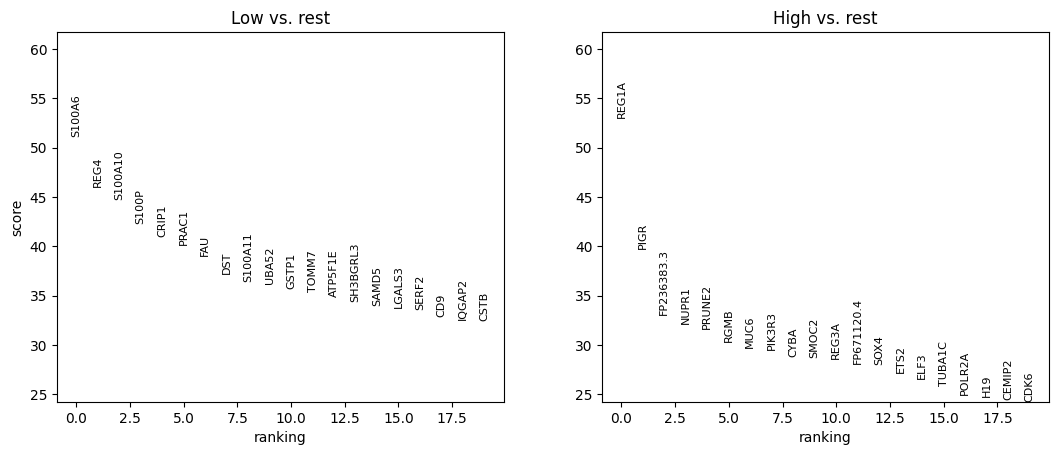

In [15]:
sc.tl.rank_genes_groups(adata_epi_chen_tumor_copy, groupby='MSI_class', method='wilcoxon')
sc.pl.rank_genes_groups(adata_epi_chen_tumor_copy, groupby='MSI_class', )

#### Select good DEGs

In [16]:
lfc_threshold = -120
FDR_threshold = 0.01

<Axes: xlabel='MSI_class', ylabel='LFC'>

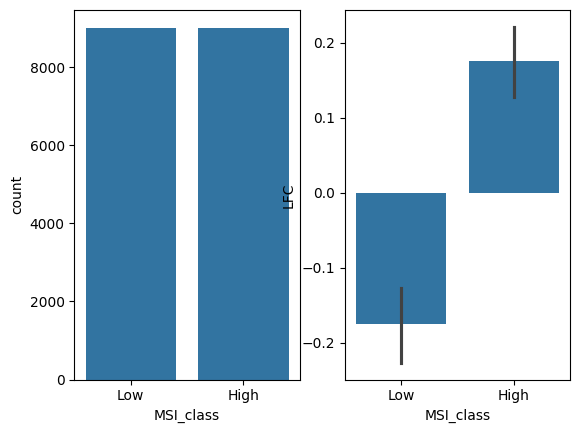

In [561]:
# Joanito
Joanito_DEGs = list()
for MSI_class in ['Low','High']:
    for idx, gene in enumerate(adata_epi_joanito_tumor_copy.uns['rank_genes_groups']['names'][MSI_class]):
        FDR = adata_epi_joanito_tumor_copy.uns['rank_genes_groups']['pvals_adj'][MSI_class][idx]
        LFC = adata_epi_joanito_tumor_copy.uns['rank_genes_groups']['logfoldchanges'][MSI_class][idx]

        Joanito_DEGs.append([MSI_class, gene, FDR, LFC, ])
            
Joanito_DEGs = pd.DataFrame(Joanito_DEGs, columns=['MSI_class', 'gene', 'FDR', 'LFC', ])

fig, axes = plt.subplots(1, 2, sharex=True,)
sns.countplot(data=Joanito_DEGs, x='MSI_class', ax=axes[0])
sns.barplot(data=Joanito_DEGs, x='MSI_class', y='LFC', ax=axes[1])

<Axes: xlabel='MSI_class', ylabel='LFC'>

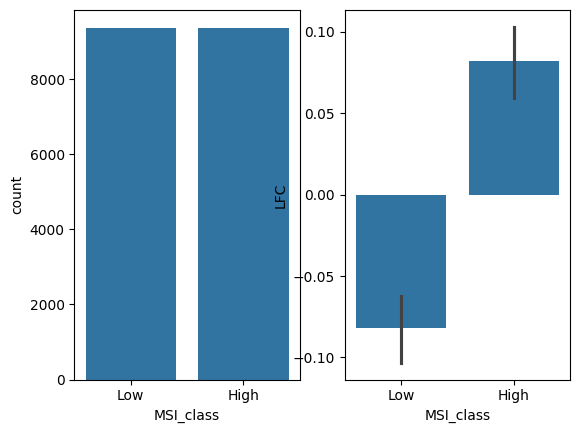

In [60]:
# Chen
Chen_DEGs = list()
for MSI_class in ['Low','High']:
    for idx, gene in enumerate(adata_epi_chen_tumor_copy.uns['rank_genes_groups']['names'][MSI_class]):
        FDR = adata_epi_chen_tumor_copy.uns['rank_genes_groups']['pvals_adj'][MSI_class][idx]
        LFC = adata_epi_chen_tumor_copy.uns['rank_genes_groups']['logfoldchanges'][MSI_class][idx]
                
        Chen_DEGs.append([MSI_class, gene, FDR, LFC,])
            
Chen_DEGs = pd.DataFrame(Chen_DEGs, columns=['MSI_class', 'gene', 'FDR', 'LFC', ])

fig, axes = plt.subplots(1, 2, sharex=True,)
sns.countplot(data=Chen_DEGs, x='MSI_class', ax=axes[0])
sns.barplot(data=Chen_DEGs, x='MSI_class', y='LFC', ax=axes[1])

In [53]:
min_fdr = Joanito_DEGs[Joanito_DEGs['FDR'] > 0]['FDR'].min()
Joanito_DEGs['adjusted_FDR'] = Joanito_DEGs['FDR'].replace(0, min_fdr)

In [55]:
Joanito_DEGs_oi = Joanito_DEGs[(Joanito_DEGs['MSI_class']=='High')].copy()
Joanito_DEGs_oi

MSI_class      gene            FDR        LFC   adjusted_FDR
9012       High  MARCKSL1  6.993083e-182   3.502661  6.993083e-182
9013       High      LDHB  3.833623e-179   8.698606  3.833623e-179
9014       High    PRSS21  6.474322e-178  32.526733  6.474322e-178
9015       High     NUPR1  4.234202e-173   8.487863  4.234202e-173
9016       High   ATP5F1D  1.004866e-167   3.965939  1.004866e-167
...         ...       ...            ...        ...            ...
18019      High     IFI27  7.067387e-183 -10.257536  7.067387e-183
18020      High      TFF1  7.769681e-184  -7.463817  7.769681e-184
18021      High    LGALS4  2.112260e-184  -4.074058  2.112260e-184
18022      High  C19orf33  2.112260e-184  -9.106847  2.112260e-184
18023      High    S100A6  2.160676e-186  -4.961553  2.160676e-186

[9012 rows x 5 columns]

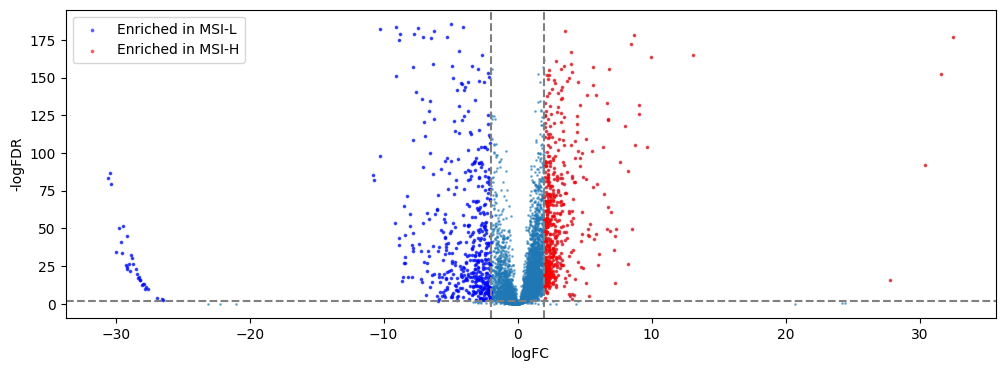

In [56]:
plt.figure(figsize=(12, 4))
plt.scatter(x=Joanito_DEGs_oi['LFC'],y=Joanito_DEGs_oi['FDR'].apply(lambda x:-np.log10(x)),s=1, alpha=0.5,)

Joanito_down = Joanito_DEGs_oi[(Joanito_DEGs_oi['LFC']<=-2)&(Joanito_DEGs_oi['FDR']<=0.01)]
Joanito_up = Joanito_DEGs_oi[(Joanito_DEGs_oi['LFC']>=2)&(Joanito_DEGs_oi['FDR']<=0.01)]

# for i,r in Joanito_up.iterrows():
#     if 'S100' in r.gene:
#         plt.text(x=r['LFC'],y=-np.log10(r['FDR']),s=r.gene)
    
    
plt.scatter(x=Joanito_down['LFC'],y=Joanito_down['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Enriched in MSI-L",color="blue", alpha=0.5,)
plt.scatter(x=Joanito_up['LFC'],y=Joanito_up['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Enriched in MSI-H",color="red", alpha=0.5,)

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

/tmp/ipykernel_108656/3835674490.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=Chen_DEGs_oi['LFC'],y=Chen_DEGs_oi['FDR'].apply(lambda x:-np.log10(x)),s=1, alpha=0.5,)
/tmp/ipykernel_108656/3835674490.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=Chen_down['LFC'],y=Chen_down['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Enriched in MSI-L",color="blue", alpha=0.5,)
/tmp/ipykernel_108656/3835674490.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=Chen_up['LFC'],y=Chen_up['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Enriched in MSI-H",color="red", alpha=0.5,)


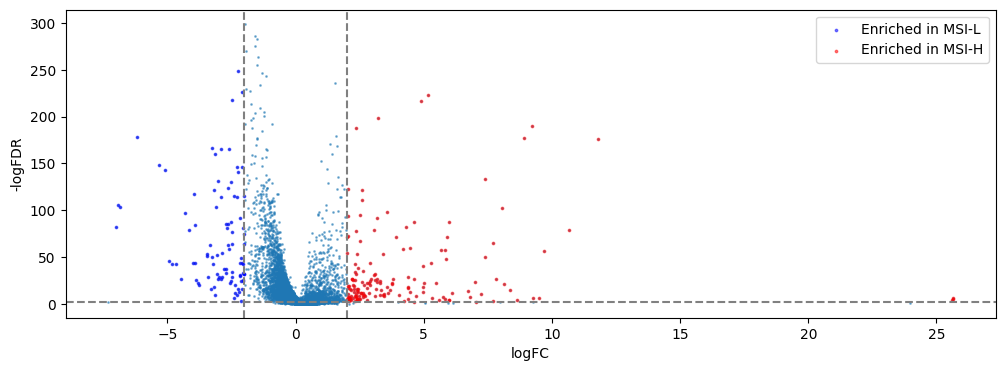

In [62]:
Chen_DEGs_oi = Chen_DEGs[(Chen_DEGs['MSI_class']=='High')]

plt.figure(figsize=(12, 4))
plt.scatter(x=Chen_DEGs_oi['LFC'],y=Chen_DEGs_oi['FDR'].apply(lambda x:-np.log10(x)),s=1, alpha=0.5,)

Chen_down = Chen_DEGs_oi[(Chen_DEGs_oi['LFC']<=-2)&(Chen_DEGs_oi['FDR']<=0.01)]
Chen_up = Chen_DEGs_oi[(Chen_DEGs_oi['LFC']>=2)&(Chen_DEGs_oi['FDR']<=0.01)]

plt.scatter(x=Chen_down['LFC'],y=Chen_down['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Enriched in MSI-L",color="blue", alpha=0.5,)
plt.scatter(x=Chen_up['LFC'],y=Chen_up['FDR'].apply(lambda x:-np.log10(x)),s=3,label="Enriched in MSI-H",color="red", alpha=0.5,)

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

In [65]:
def LFC_to_probableMSIclass(LFC):
    if LFC > 0: return 'MSI-H'
    else: return 'MSI-L'
    
Chen_DEGs['ProbableMSIClass']       = [ LFC_to_probableMSIclass(lfc) for lfc in Chen_DEGs['LFC'] ]
Joanito_DEGs['ProbableMSIClass']    = [ LFC_to_probableMSIclass(lfc) for lfc in Joanito_DEGs['LFC'] ]

In [66]:
Joanito_DEGs_MSI_H = Joanito_DEGs[(Joanito_DEGs['MSI_class']=='High') & 
                               (Joanito_DEGs['adjusted_FDR']<=0.01) & 
                               (Joanito_DEGs['LFC']>=2)].copy()
Joanito_DEGs_MSI_L = Joanito_DEGs[(Joanito_DEGs['MSI_class']=='Low') & 
                               (Joanito_DEGs['adjusted_FDR']<=0.01) & 
                               (Joanito_DEGs['LFC']<=-2)].copy()

# Chen_DEGs_MSI_H = Chen_DEGs[(Chen_DEGs['MSI_class']=='High') & 
#                             (Chen_DEGs['adjusted_FDR']<=0.01) & 
#                             (Chen_DEGs['LFC']>=2)].copy()
# Chen_DEGs_MSI_L = Chen_DEGs[(Chen_DEGs['MSI_class']=='Low') & 
#                             (Chen_DEGs['adjusted_FDR']<=0.01) & 
#                             (Chen_DEGs['LFC']<=-2)].copy()

Intersecting_DEGs_MSI_H = Chen_DEGs[(Chen_DEGs['MSI_class']=='High')].copy()
Intersecting_DEGs_MSI_H['ProbableMSIClass'] = [ LFC_to_probableMSIclass(lfc) for lfc in Intersecting_DEGs_MSI_H['LFC'] ]
Intersecting_DEGs_MSI_H = Intersecting_DEGs_MSI_H[Intersecting_DEGs_MSI_H['ProbableMSIClass']=='MSI-H']
Intersecting_DEGs_MSI_H = Intersecting_DEGs_MSI_H[Intersecting_DEGs_MSI_H['gene'].isin( Joanito_DEGs[(Joanito_DEGs['MSI_class']=='High') & (Joanito_DEGs['ProbableMSIClass']=='MSI-H')]['gene'] )]

Intersecting_DEGs_MSI_L = Chen_DEGs[(Chen_DEGs['MSI_class']=='High')].copy()
Intersecting_DEGs_MSI_L['ProbableMSIClass'] = [ LFC_to_probableMSIclass(lfc) for lfc in Intersecting_DEGs_MSI_L['LFC'] ]
Intersecting_DEGs_MSI_L = Intersecting_DEGs_MSI_L[Intersecting_DEGs_MSI_L['ProbableMSIClass']=='MSI-L']
Intersecting_DEGs_MSI_L = Intersecting_DEGs_MSI_L[Intersecting_DEGs_MSI_L['gene'].isin( Joanito_DEGs[(Joanito_DEGs['MSI_class']=='High') & (Joanito_DEGs['ProbableMSIClass']=='MSI-L')]['gene'] )]

Intersecting_DEGs_MSI_L.shape, Intersecting_DEGs_MSI_H.shape
Intersecting_DEGs = pd.concat([Intersecting_DEGs_MSI_H, Intersecting_DEGs_MSI_L])
Intersecting_DEGs.reset_index(inplace=True, drop=True)
Intersecting_DEGs

MSI_class     gene            FDR       LFC ProbableMSIClass
0         High     PIGR   0.000000e+00  2.398711            MSI-H
1         High    NUPR1  3.398969e-224  5.157847            MSI-H
2         High   PRUNE2  4.906630e-217  4.876456            MSI-H
3         High     RGMB  5.936571e-199  3.229043            MSI-H
4         High   PIK3R3  2.706879e-188  2.365482            MSI-H
...        ...      ...            ...       ...              ...
4240      High    CRIP1   0.000000e+00 -1.806866            MSI-L
4241      High    S100P   0.000000e+00 -1.963216            MSI-L
4242      High  S100A10   0.000000e+00 -1.972037            MSI-L
4243      High     REG4   0.000000e+00 -3.123585            MSI-L
4244      High   S100A6   0.000000e+00 -2.043979            MSI-L

[4245 rows x 5 columns]

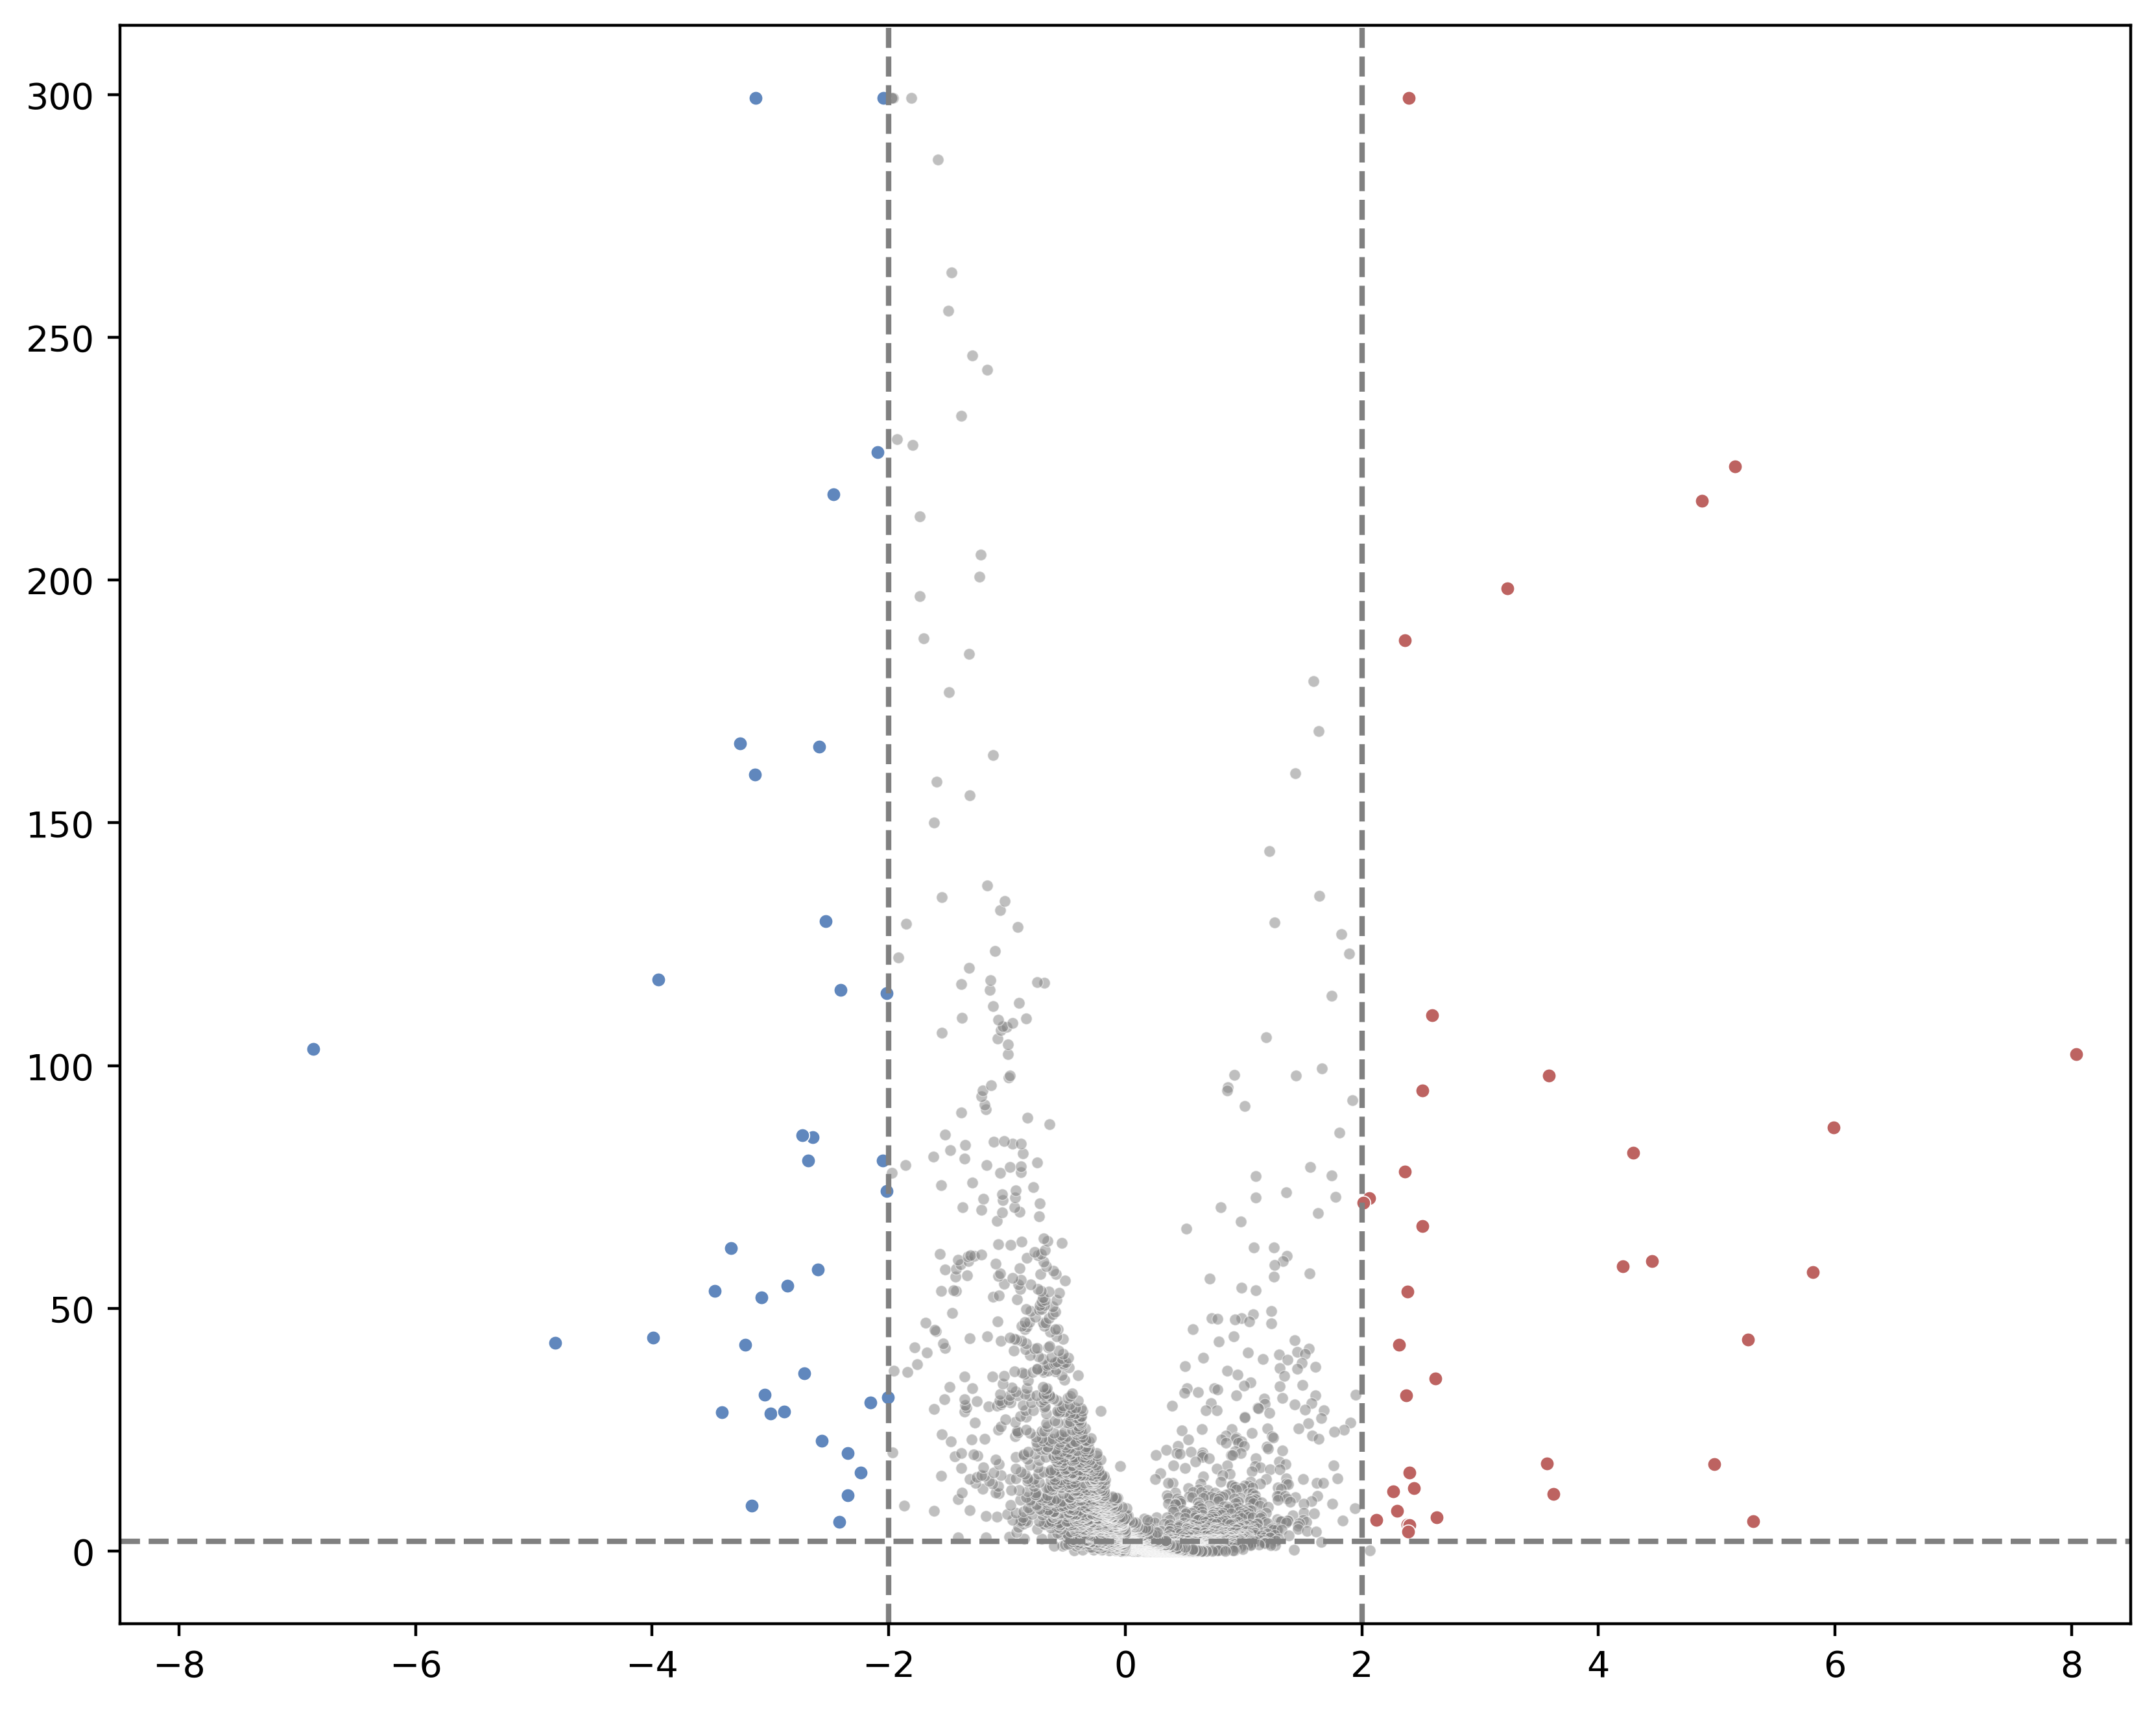

In [68]:
# Chen_DEGs_oi = Chen_DEGs[(Chen_DEGs['MSI_class']=='High') & (Chen_DEGs['gene'].isin(Joanito_DEGs_oi['gene']))].copy()
min_fdr = Intersecting_DEGs[Intersecting_DEGs['FDR'] > 0]['FDR'].min()
Intersecting_DEGs['adjusted_FDR'] = Intersecting_DEGs['FDR'].replace(0, min_fdr)
Intersecting_DEGs['-logFDR'] = [ -np.log10(FDR) for FDR in Intersecting_DEGs['adjusted_FDR'] ]

plt.figure(figsize=(10, 8), dpi=400)
sns.scatterplot(x=Intersecting_DEGs['LFC'],y=Intersecting_DEGs['adjusted_FDR'].apply(lambda x:-np.log10(x)),s=10, alpha=0.5, color='gray')

down = Intersecting_DEGs[(Intersecting_DEGs['LFC']<=-2)&(Intersecting_DEGs['adjusted_FDR']<=0.01)]
up = Intersecting_DEGs[(Intersecting_DEGs['LFC']>=2)&(Intersecting_DEGs['adjusted_FDR']<=0.01)]
    
sns.scatterplot(x=down['LFC'],y=down['adjusted_FDR'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('vlag_r', 8)[-1], alpha=1,)
sns.scatterplot(x=up['LFC'],y=up['adjusted_FDR'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('vlag_r', 8)[0], alpha=1,)

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-8.5, 8.5]);

<Axes: xlabel='MSI_class', ylabel='KEGG_TGFB'>

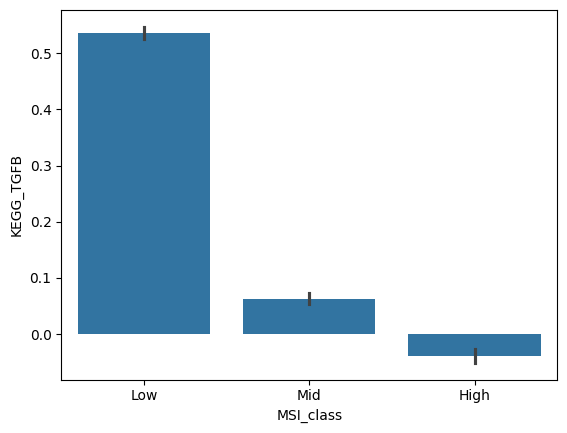

In [801]:
# sc.tl.score_genes(adata_epi_chen_tumor, gene_list=TGFB['Chen_SSL'].dropna(), score_name='KEGG_TGFB')
# sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=TGFB['Chen_SSL'].dropna(), score_name='KEGG_TGFB')

# sc.pl.violin(adata_epi_chen_tumor, keys='KEGG_TGFB', groupby='MSI_class', order=['Low', 'Mid', 'High'])
# sc.pl.violin(adata_epi_joanito_tumor, keys='KEGG_TGFB', groupby='MSI_class', order=['Low', 'Mid', 'High'])
# sns.barplot(adata_epi_chen_tumor.obs, y='KEGG_TGFB', x='MSI_class', order=['Low', 'Mid', 'High'])

# sns.barplot(adata_epi_joanito_tumor.obs, y='KEGG_TGFB', x='MSI_class', order=['Low', 'Mid', 'High'])

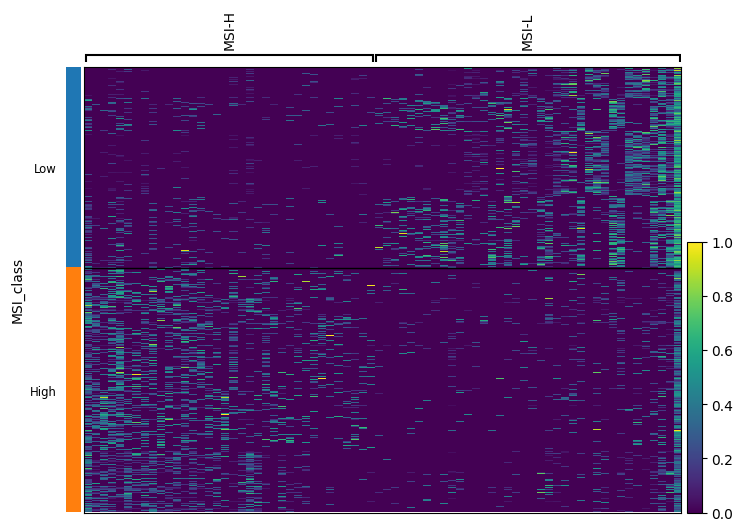

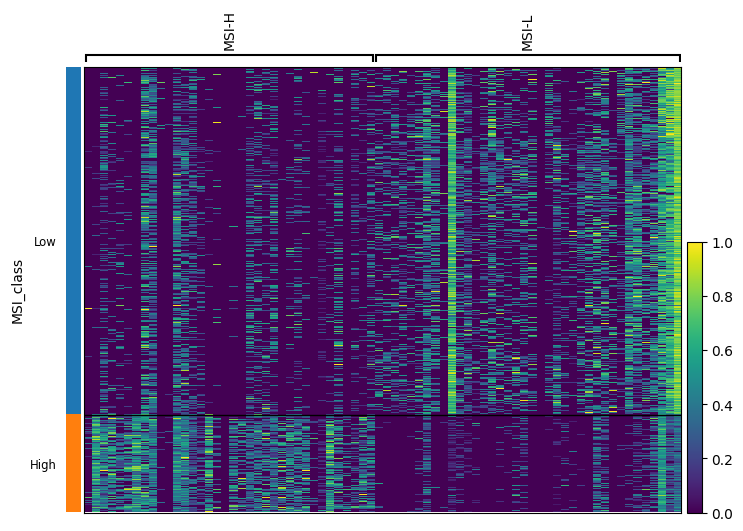

In [70]:
MSI_H_genes = Intersecting_DEGs[(Intersecting_DEGs['adjusted_FDR']<=0.01) & (Intersecting_DEGs['LFC']>=2)]['gene']
MSI_L_genes = Intersecting_DEGs[(Intersecting_DEGs['adjusted_FDR']<=0.01) & (Intersecting_DEGs['LFC']<=-2)]['gene']

sc.pl.heatmap(adata_epi_chen_tumor_copy, var_names={'MSI-H' : MSI_H_genes, 'MSI-L' : MSI_L_genes}, groupby='MSI_class', standard_scale='var', 
              # categories_order=['Low', 'Mid', 'High'],
              )
sc.pl.heatmap(adata_epi_joanito_tumor_copy, var_names={'MSI-H' : MSI_H_genes, 'MSI-L' : MSI_L_genes}, groupby='MSI_class', standard_scale='var', 
              # categories_order=['Low', 'Mid', 'High'],
              )

### Find MSigDB gene set associated with the identified genes 

In [50]:
MSI_L_related_genes = [
    'S100A6',
    'REG4',
    'COMMD6',
    'SYTL2',
    'SERPINB5',
    'LINC02086',
    'CDKN2A',
    'NPW',
    'S100A4',
    'S100A2'
]
MSI_H_related_genes = [
    'PIGR',
    'NUPR1',
    'RGMB',
    'PRUNE2',
    'PIK3R3',
    'PLCB1',
    'GNGT1',
]

#### MSigDB HALLMARK genes

In [ ]:
 #! MSigDB HALLMARK gene set
MSigDB_hallmark = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/MSigDB/h.all.v2024.1.Hs.symbols.gmt', sep='\t', header=None)
MSigDB_hallmark.columns = ['hallmark_name', 'url', ] + [ i for i in range(len(MSigDB_hallmark.columns)-2) ]

dict_hallmark_to_MSI_L_geneCount = dict()
dict_hallmark_to_MSI_H_geneCount = dict()

for tup in MSigDB_hallmark.itertuples():
    
    genes = [g for g in list(tup[3:]) if type(g)==str]
    intersectingGeneCount_MSI_L = len(set(genes).intersection(set(MSI_L_related_genes)))
    intersectingGeneCount_MSI_H = len(set(genes).intersection(set(MSI_H_related_genes)))
    
    if intersectingGeneCount_MSI_L != 0:
        dict_hallmark_to_MSI_L_geneCount[tup[1]] = intersectingGeneCount_MSI_L
    if intersectingGeneCount_MSI_H != 0:
        dict_hallmark_to_MSI_H_geneCount[tup[1]] = intersectingGeneCount_MSI_H

dict_hallmark_to_MSI_L_geneCount = dict(sorted(dict_hallmark_to_MSI_L_geneCount.items(), key=lambda x:x[1], reverse=True))
dict_hallmark_to_MSI_H_geneCount = dict(sorted(dict_hallmark_to_MSI_H_geneCount.items(), key=lambda x:x[1], reverse=True))

dict_hallmark_to_MSI_L_geneCount

#### MSigDB curated gene set

In [ ]:
 #! MSigDB Curated gene set 
file_path = '/node200data/18parkky/datasets/reference/marker_genes/MSigDB/c2.all.v2024.1.Hs.symbols.gmt'
data = []

with open(file_path, "r") as f:
    for line in f:
        data.append(line.strip().split("\t"))  # Split by tab

# Find the maximum number of columns
max_cols = max(len(row) for row in data)

# Pad shorter rows with NaN
MSigDB_curated = pd.DataFrame([row + [None] * (max_cols - len(row)) for row in data])

dict_hallmark_to_MSI_L_geneCount = dict()
dict_hallmark_to_MSI_H_geneCount = dict()

for tup in MSigDB_curated.itertuples():
    
    genes = [g for g in list(tup[3:]) if type(g)==str]
    intersectingGeneCount_MSI_L = len(set(genes).intersection(set(MSI_L_related_genes)))
    intersectingGeneCount_MSI_H = len(set(genes).intersection(set(MSI_H_related_genes)))
    
    if intersectingGeneCount_MSI_L != 0:
        dict_hallmark_to_MSI_L_geneCount[tup[1]] = intersectingGeneCount_MSI_L
    if intersectingGeneCount_MSI_H != 0:
        dict_hallmark_to_MSI_H_geneCount[tup[1]] = intersectingGeneCount_MSI_H

dict_hallmark_to_MSI_L_geneCount = dict(sorted(dict_hallmark_to_MSI_L_geneCount.items(), key=lambda x:x[1], reverse=True))
dict_hallmark_to_MSI_H_geneCount = dict(sorted(dict_hallmark_to_MSI_H_geneCount.items(), key=lambda x:x[1], reverse=True))

### Prepare GSEA

In [182]:
# Chen et al., MSI-L
adata_epi_chen_tumor_raw = adata_epi_chen[(adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].raw.to_adata().copy()

adata_epi_chen_tumor_raw.var["mt"] = adata_epi_chen_tumor_raw.var_names.str.startswith("MT-")
adata_epi_chen_tumor_raw.var["ribo"] = adata_epi_chen_tumor_raw.var_names.str.startswith(("RPS", "RPL"))
adata_epi_chen_tumor_raw.var["hb"] = adata_epi_chen_tumor_raw.var_names.str.contains("^HB[^(P)]")
adata_epi_chen_tumor_raw = adata_epi_chen_tumor_raw[:, adata_epi_chen_tumor_raw.var.mt==False].copy()
adata_epi_chen_tumor_raw = adata_epi_chen_tumor_raw[:, adata_epi_chen_tumor_raw.var.ribo==False].copy()
adata_epi_chen_tumor_raw = adata_epi_chen_tumor_raw[:, adata_epi_chen_tumor_raw.var.hb==False].copy()

adata_epi_chen_tumor_raw.obs['MSI_class'] = [ dict_PatientID_to_MSIintensityClass[PatientID] for PatientID in adata_epi_chen_tumor_raw.obs['PatientID'] ]
adata_epi_chen_tumor_raw.obs['MSI_class'] = adata_epi_chen_tumor_raw.obs['MSI_class'].astype('category')
adata_epi_chen_tumor_raw.obs['adata_epi_chen_tumor_raw'] = adata_epi_chen_tumor_raw.obs['MSI_class'].cat.reorder_categories(['Low', 'Mid', 'High'])
adata_epi_chen_tumor_raw = adata_epi_chen_tumor_raw[adata_epi_chen_tumor_raw.obs['MSI_class']=='Low'].copy()
# adata_epi_chen_tumor_raw = adata_epi_chen_tumor_raw[:, adata_epi_chen_tumor_raw.var.index.isin( list(MSI_H_genes) + list(MSI_L_genes) )]

In [183]:
adata_epi_chen_tumor_raw_X = adata_epi_chen_tumor_raw.X.T.copy() 

chen_pseudobulk_expression = list()
for idx, arr in enumerate(adata_epi_chen_tumor_raw_X):
    chen_pseudobulk_expression.append( [adata_epi_chen_tumor_raw.var.index[idx], np.mean(arr.toarray().ravel()), ] )

chen_pseudobulk_expression = pd.DataFrame(chen_pseudobulk_expression, columns=['gene', 'avg_expression'])
chen_pseudobulk_expression.sort_values('gene').to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/GSEA/Chen_MSI_L_pseudobulk.tsv', sep='\t', index=False)

In [199]:
chen_pseudobulk_expression_MSI_H = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/GSEA/Chen_MSI_H_pseudobulk.tsv', sep='\t')
chen_pseudobulk_expression_MSI_H.columns = ['NAME', 'Chen_MSI_H']
chen_pseudobulk_expression_MSI_L = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/GSEA/Chen_MSI_L_pseudobulk.tsv', sep='\t')
chen_pseudobulk_expression_MSI_L.columns = ['NAME2', 'Chen_MSI_L']
chen_pseudobulk_expression = pd.concat([chen_pseudobulk_expression_MSI_L, chen_pseudobulk_expression_MSI_H], axis=1)
chen_pseudobulk_expression = chen_pseudobulk_expression[['NAME', 'Chen_MSI_L', 'Chen_MSI_H']]
chen_pseudobulk_expression['DESCRIPTION'] = 'na'
chen_pseudobulk_expression.reset_index(inplace=True, drop=True)

chen_pseudobulk_expression[['NAME', 'DESCRIPTION', 'Chen_MSI_L', 'Chen_MSI_H']].to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/GSEA/Chen_pseudobulk.input.txt', sep='\t', index=False)

In [123]:
set(adata_epi_chen[(adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial') : (adata_epi_chen.var.index.isin(list(MSI_H_genes) + list(MSI_L_genes)))].raw.to_adata().X[0].toarray().ravel())

TypeError: cannot do positional indexing on Index with these indexers [AAACGGGAGCCAGAAC-1      False
AAACGGGCAAAGTGCG-1      False
AAAGATGGTGGTAACG-1      False
AAAGCAATCTGCTTGC-1      False
AAATGCCAGCGATAGC-1      False
                        ...  
TTTGGTTTCCGGGTGT-1-3     True
TTTGTCACACAGATTC-1       True
TTTGTCAGTAGTAGTA-1      False
TTTGTCAGTTCAGGCC-1-1     True
TTTGTCATCGCATGAT-1-1    False
Name: Manual_CellType_lvl_1, Length: 36023, dtype: bool] of type Series

In [105]:
epi_chen_tumor_MSI_genes_X = adata_epi_chen_tumor_copy[:, adata_epi_chen_tumor_copy.var.index.isin(list(MSI_H_genes) + list(MSI_L_genes))].X.copy()

# import scipy.sparse as sp
# if sp.issparse(epi_chen_tumor_MSI_genes_X):
#     epi_chen_tumor_MSI_genes_X = epi_chen_tumor_MSI_genes_X.toarray()
    
# df = pd.DataFrame(epi_chen_tumor_MSI_genes_X.T, 
#                   index=adata_epi_chen_tumor_copy[:, adata_epi_chen_tumor_copy.var.index.isin(list(MSI_H_genes) + list(MSI_L_genes))].var_names, 
#                   columns=['Chen'])
# df

AttributeError: 'NoneType' object has no attribute 'to_adata'

## Inter-patient comparison: Low vs. Mid vs. High

In [ ]:
sc

### Joanito

In [302]:
dict_PatientID_to_AvgAvgSTRDiff = { PatientID : np.mean(edf['AvgSTRDiff']) for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID', observed=True,) }
dict_PatientID_to_MSIintensityClass = { 'SC044' : 'High', 'SC035' : 'Mid', 'CRC2783' : 'Mid', 'CRC2817' : 'Low' }
adata_epi_joanito_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSIintensityClass[PatientID] for PatientID in adata_epi_joanito_tumor.obs['PatientID'] ]
adata_epi_joanito_tumor.obs['MSI_class'] = adata_epi_joanito_tumor.obs['MSI_class'].astype('category')
adata_epi_joanito_tumor.obs['MSI_class'] = adata_epi_joanito_tumor.obs['MSI_class'].cat.reorder_categories(['Low', 'Mid', 'High'])

dict_PatientID_to_MSIintensityClassCrude = { 'SC044' : 'High', 'SC035' : 'High', 'CRC2783' : 'High', 'CRC2817' : 'Low' }
adata_epi_joanito_tumor.obs['MSI_class_crude'] = [ dict_PatientID_to_MSIintensityClassCrude[PatientID] for PatientID in adata_epi_joanito_tumor.obs['PatientID'] ]
adata_epi_joanito_tumor.obs['MSI_class_crude'] = adata_epi_joanito_tumor.obs['MSI_class_crude'].astype('category')
adata_epi_joanito_tumor.obs['MSI_class_crude'] = adata_epi_joanito_tumor.obs['MSI_class_crude'].cat.reorder_categories(['Low', 'High'])

In [608]:
u, s = np.mean(adata_epi_joanito_tumor.obs['AvgSTRDiff']), np.std(adata_epi_joanito_tumor.obs['AvgSTRDiff'])
adata_epi_joanito_tumor.obs['AvgSTRDiff_scaled'] = [ (ASD-u)/s for ASD in adata_epi_joanito_tumor.obs['AvgSTRDiff'] ]

u, s = np.mean(adata_epi_joanito_tumor.obs['StdSTRDiff']), np.std(adata_epi_joanito_tumor.obs['StdSTRDiff'])
adata_epi_joanito_tumor.obs['StdSTRDiff_scaled'] = [ (SSD-u)/s for SSD in adata_epi_joanito_tumor.obs['StdSTRDiff'] ]

In [614]:
sns.color_palette('vlag_r', 8)

[(0.74073277, 0.38723941, 0.3813074),
 (0.81052113, 0.55092973, 0.54052443),
 (0.88153537, 0.72369332, 0.71478461),
 (0.9593079, 0.89791478, 0.89259122),
 (0.91998105, 0.91766106, 0.93431861),
 (0.74094862, 0.77809393, 0.84474951),
 (0.55912585, 0.64719519, 0.77875327),
 (0.37649902, 0.52976642, 0.74207698)]

Text(0, 0.5, '')

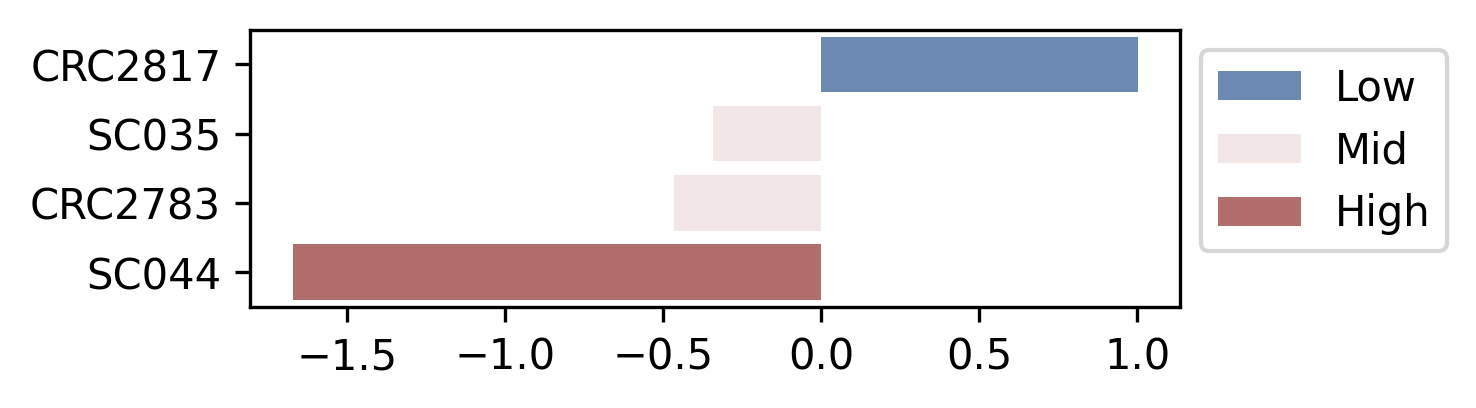

In [627]:
plt.figure(figsize=(4, 1.2), dpi=300)
ax = sns.barplot(data=adata_epi_joanito_tumor.obs, y='PatientID', x='AvgSTRDiff_scaled', 
                 errorbar=None, order=['CRC2817', 'SC035', 'CRC2783', 'SC044'], 
                 hue='MSI_class',
                 # palette={'Low' : 'blue', 'Mid' : 'green', 'High' : 'red'},
                 palette={ 'Low' : sns.color_palette('vlag_r', 8)[-1], 'Mid' : sns.color_palette('vlag_r', 8)[3], 'High' : sns.color_palette('vlag_r', 8)[0] }
                 )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='', )
ax.set_xlabel('')
ax.set_ylabel('')


In [ ]:
sns.barplot(data=adata_epi_joanito_tumor.obs, x='MSI_class', y='AvgSTRDiff', errorbar=None, order=['CRC2817', 'SC035', 'CRC2783', 'SC044'], hue='MSI_class')

In [305]:
adata_epi_joanito_tumor_copy = adata_epi_joanito_tumor.copy()

In [306]:
sc.pp.filter_genes(adata_epi_joanito_tumor_copy, min_counts=500)
adata_epi_joanito_tumor_copy

AnnData object with n_obs × n_vars = 3490 × 9120
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'leiden', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'BiopsySite2', 'Manual_CellType_lvl_1', 'MSI_class', 'MSI_class_crude'
    var: 'n_cells', 'n_counts'
    uns: 'Author_CellType_lvl_1_colors', 'BiopsySite_colors', 'Manual_CellType_lvl_1_colors', 'PatientID_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

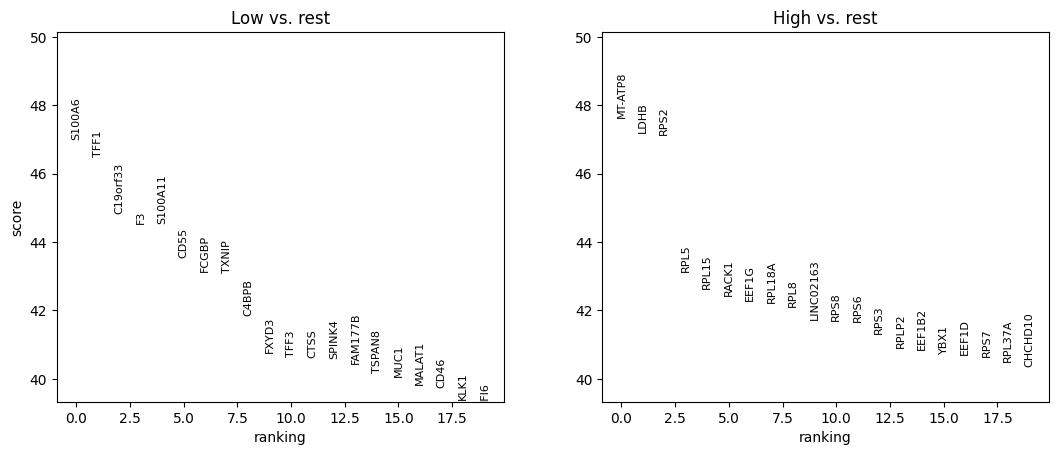

In [307]:
sc.tl.rank_genes_groups(adata_epi_joanito_tumor_copy, groupby='MSI_class_crude', method='wilcoxon')
sc.pl.rank_genes_groups(adata_epi_joanito_tumor_copy, groupby='MSI_class_crude', )

In [ ]:
# ~50 minutes
DEG_Summary = list()
for MSI_class in ['Low', 'Mid', 'High']:
    for idx, gene in enumerate(adata_epi_joanito_tumor.uns['rank_genes_groups']['names'][MSI_class]):
        pvals_adj = adata_epi_joanito_tumor.uns['rank_genes_groups']['pvals_adj'][MSI_class][idx]
        lfc = adata_epi_joanito_tumor.uns['rank_genes_groups']['logfoldchanges'][MSI_class][idx]
        
        gene_idx = list(adata_epi_joanito_tumor.var.index).index(gene)
        ExpressionArray = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']==MSI_class].X.T[gene_idx].toarray()
        
        DEG_Summary.append( [MSI_class, gene, pvals_adj, lfc, np.mean(ExpressionArray), np.std(ExpressionArray)] )

DEG_Summary = pd.DataFrame(DEG_Summary, columns=['MSI_class', 'gene', 'pvals_adj', 'lfc', 'avgExpression', 'stdExpression'])
# DEG_Summary.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/DEG_by_MSIclass.tsv', sep='\t', index=False)

In [112]:
DEG_Summary = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/DEG_by_MSIclass.tsv', sep='\t',)

candidateDriverGenes = list()
import scipy.stats
for gene, edf in DEG_Summary.groupby('gene'):
    if min(edf['pvals_adj'])>0.05: continue 
    # if max(edf['avgExpression']< 0.5): continue
    # if max(edf['stdExpression']> 0.8): continue
    
    
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    try:
        bool_pos_cor = bool((dict_MSI_class_to_avgExpression['High']/dict_MSI_class_to_avgExpression['Mid']>=1) and (dict_MSI_class_to_avgExpression['Mid']/dict_MSI_class_to_avgExpression['Low']>=1))
        bool_neg_cor = bool((dict_MSI_class_to_avgExpression['Low']/dict_MSI_class_to_avgExpression['Mid']>=1) and (dict_MSI_class_to_avgExpression['Mid']/dict_MSI_class_to_avgExpression['High']>=1))
        if bool_pos_cor==False and bool_neg_cor==False:
            continue
    except ZeroDivisionError: pass 
    
    if (dict_MSI_class_to_avgExpression['Low'] < dict_MSI_class_to_avgExpression['Mid'] < dict_MSI_class_to_avgExpression['High']) or (dict_MSI_class_to_avgExpression['Low'] > dict_MSI_class_to_avgExpression['Mid'] > dict_MSI_class_to_avgExpression['High']):
        dict_MSI_class_to_lfc = { tup.MSI_class : tup.lfc for tup in edf.itertuples() }
        if (dict_MSI_class_to_lfc['Low'] < dict_MSI_class_to_lfc['Mid'] < dict_MSI_class_to_lfc['High']) or (dict_MSI_class_to_lfc['Low'] > dict_MSI_class_to_lfc['Mid'] > dict_MSI_class_to_lfc['High']):
            candidateDriverGenes.append( gene )
        else:
            pass 
    else:
        pass
        
DEG_Summary_filtered = DEG_Summary[(DEG_Summary['gene'].isin(candidateDriverGenes))].copy()
candidateDriverGenes = list()
for gene, edf in DEG_Summary_filtered.groupby('gene'):
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    r, pval = scipy.stats.pearsonr( [1,2,3], [dict_MSI_class_to_avgExpression['Low'], dict_MSI_class_to_avgExpression['Mid'], dict_MSI_class_to_avgExpression['High']] )
    candidateDriverGenes.append( [gene, r, pval] )
candidateDriverGenes = pd.DataFrame(candidateDriverGenes, columns=['gene', 'r', 'pval'])
candidateDriverGenes.shape

(3302, 3)

In [121]:
candidateDriverGenes.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SelectedDriverGenes.tsv', sep='\t', index=False)

In [33]:
adata_epi_joanito_tumor.obs['MSI_class2'] = [ bool(MSI_class=='Low') for MSI_class in adata_epi_joanito_tumor.obs['MSI_class'] ]

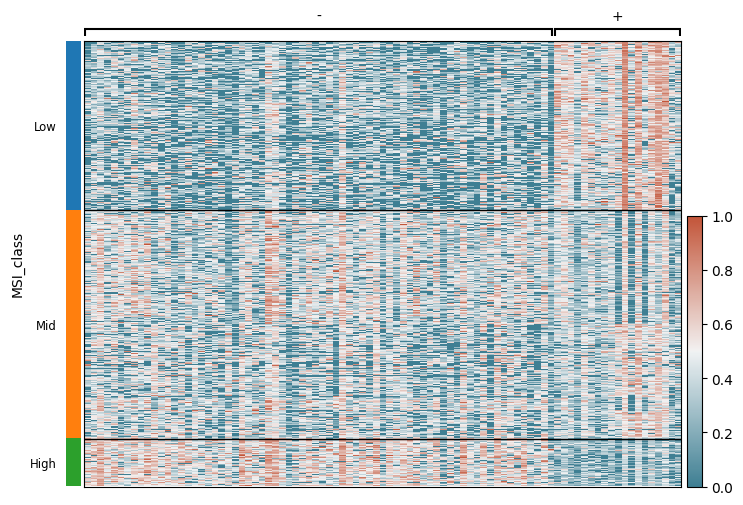

In [30]:
sc.pl.heatmap(adata_epi_joanito_tumor, 
              var_names={ '-' : candidateDriverGenes[(candidateDriverGenes['pval']<=0.05) & (candidateDriverGenes['r']>=0.5)]['gene'], 
                         '+' : candidateDriverGenes[(candidateDriverGenes['pval']<=0.05) & (candidateDriverGenes['r']<=-0.5)]['gene'] }, 
              groupby='MSI_class', 
              standard_scale='var', 
              # show_gene_labels=True, 

              cmap=sns.diverging_palette(220, 20, as_cmap=True),
              )

In [91]:
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes[(candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']>=0.5)]['gene'], score_name='Joanito_MSI_H')
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes[(candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']<=-0.5)]['gene'], score_name='Joanito_MSI_L')

sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes[(candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']>=0.5)]['gene'], score_name='Joanito_MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes[ (candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']<=-0.5)]['gene'], score_name='Joanito_MSI_L')

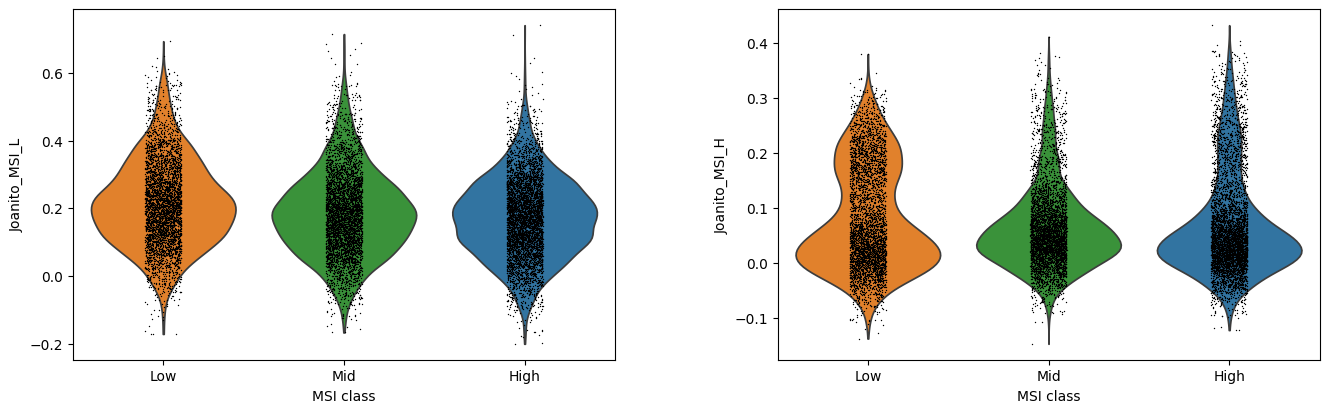

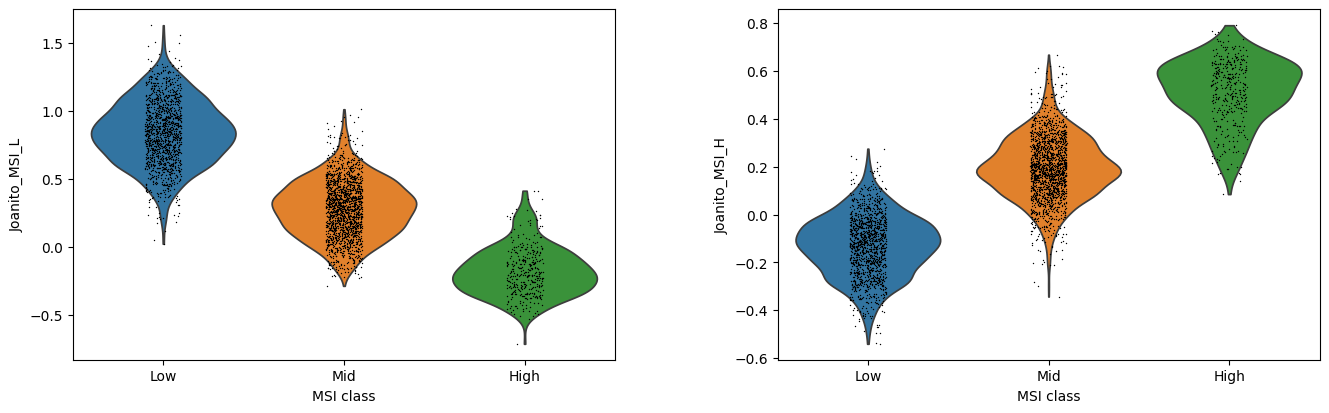

In [94]:
sc.pl.violin(adata_epi_chen_tumor, keys=['Joanito_MSI_L', 'Joanito_MSI_H'], groupby='MSI_class', order=['Low', 'Mid', 'High'])
sc.pl.violin(adata_epi_joanito_tumor, keys=['Joanito_MSI_L', 'Joanito_MSI_H'], groupby='MSI_class', order=['Low', 'Mid', 'High'])

In [80]:
dict_PatientID_to_AvgAvgSTRDiff
adata_epi_chen_tumor.obs['AvgAvgSTRDiff'] = [ dict_PatientID_to_AvgAvgSTRDiff[PID] for PID in adata_epi_chen_tumor.obs['PatientID'] ]

In [ ]:
l = list()
for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID', observed=True):
    if PatientID=='P18': continue
    l.append( [PatientID, np.mean(edf['Joanito_MSI_H']), np.mean(edf['Joanito_MSI_L']), edf.iloc[0].AvgAvgSTRDiff] )
l = pd.DataFrame(l, columns=['PatientID', 'Joanito_MSI_H', 'Joanito_MSI_L', 'AvgAvgSTRDiff'])


sns.regplot(data=l, x='Joanito_MSI_L', y='AvgAvgSTRDiff')
scipy.stats.pearsonr( x=l['Joanito_MSI_L'], y=l['AvgAvgSTRDiff'] )

In [108]:
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes[(candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']>=0.5)]['gene'], score_name='Chen_MSI_H')
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes[(candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']<=-0.5)]['gene'], score_name='Chen_MSI_L')

sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes[(candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']>=0.5)]['gene'], score_name='Chen_MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes[ (candidateDriverGenes['pval']<=0.1) & (candidateDriverGenes['r']<=-0.5)]['gene'], score_name='Chen_MSI_L')

In [ ]:
genesOfInterset = ['PRSS21', 'EEF1G', 'NUPR1', 'TFF1']
sc.pl.dotplot(adata_epi_joanito_tumor, var_names=genesOfInterset, groupby='MSI_class', categories_order=['Low', 'Mid', 'High'])
sc.pl.dotplot(adata_epi_chen_tumor, var_names=genesOfInterset, groupby='MSI_class', categories_order=['Low', 'Mid', 'High'])

In [ ]:
sc.pl.rank_genes_groups(adata_epi_joanito_tumor, groupby='MSI_class')

### Chen

In [335]:
dict_PatientID_to_AvgAvgSTRDiff = { PatientID : np.mean(edf['AvgSTRDiff']) for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID', observed=True,) }
dict_PatientID_to_AvgAvgSTRDiff = dict(sorted(dict_PatientID_to_AvgAvgSTRDiff.items(), key=lambda x:x[1]))
dict_PatientID_to_MSIintensityClass = { 'P04' : 'High', 
                                       'P21' : 'High', 
                                       'P23' : 'High', 
                                       'P22' : 'High', 
                                       'P19' : 'Mid', 
                                       'P20' : 'Mid', 
                                       'P26' : 'Mid', 
                                       'P15' : 'Mid', 
                                       'P17' : 'Low', 
                                       'P18' : 'Low',
                                       }
adata_epi_chen_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSIintensityClass[PatientID] for PatientID in adata_epi_chen_tumor.obs['PatientID'] ]


dict_PatientID_to_MSIintensityClassCrude = { 'P04' : 'High', 
                                       'P21' : 'High', 
                                       'P23' : 'High', 
                                       'P22' : 'High', 
                                       'P19' : 'High', 
                                       'P20' : 'High', 
                                       'P26' : 'High', 
                                       'P15' : 'High', 
                                       'P17' : 'Low', 
                                       'P18' : 'Low',
                                       }
adata_epi_chen_tumor.obs['MSI_class_crude'] = [ dict_PatientID_to_MSIintensityClassCrude[PatientID] for PatientID in adata_epi_chen_tumor.obs['PatientID'] ]
adata_epi_chen_tumor.obs['MSI_class_crude'] = adata_epi_chen_tumor.obs['MSI_class_crude'].astype('category')
adata_epi_chen_tumor.obs['MSI_class_crude'] = adata_epi_chen_tumor.obs['MSI_class_crude'].cat.reorder_categories(['Low', 'High'])

In [621]:
u, s = np.mean(adata_epi_chen_tumor.obs['AvgSTRDiff']), np.std(adata_epi_chen_tumor.obs['AvgSTRDiff'])
adata_epi_chen_tumor.obs['AvgSTRDiff_scaled'] = [ (ASD-u)/s for ASD in adata_epi_chen_tumor.obs['AvgSTRDiff'] ]

u, s = np.mean(adata_epi_chen_tumor.obs['StdSTRDiff']), np.std(adata_epi_chen_tumor.obs['StdSTRDiff'])
adata_epi_chen_tumor.obs['StdSTRDiff_scaled'] = [ (SSD-u)/s for SSD in adata_epi_chen_tumor.obs['StdSTRDiff'] ]

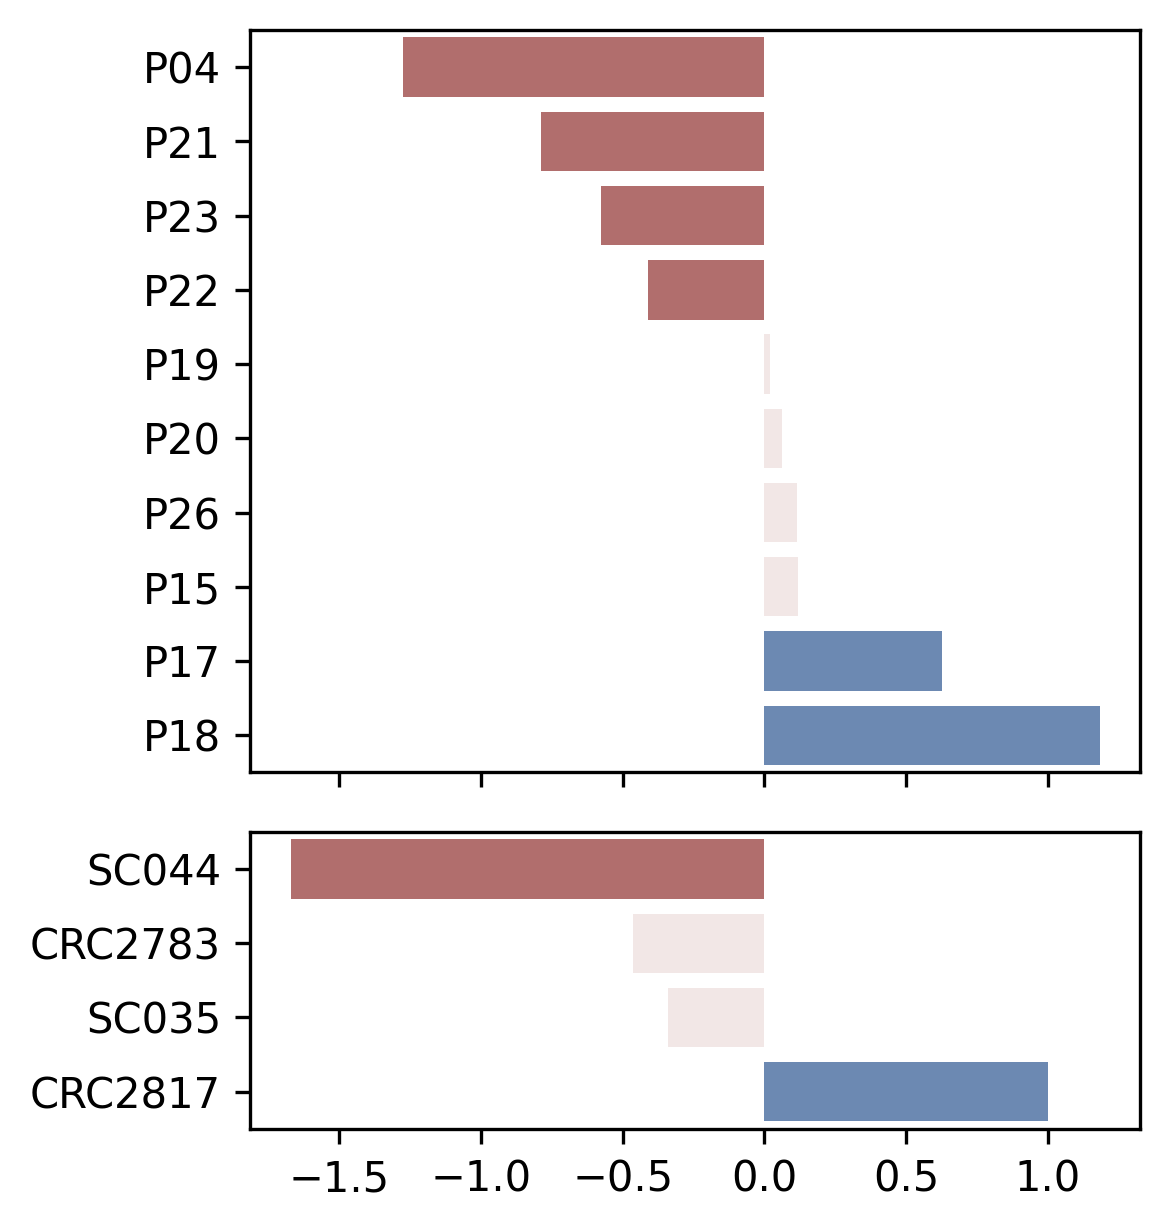

In [637]:
# plt.figure(figsize=(4, 3), dpi=300)

fig, axes = plt.subplots(2, 1, figsize=(4, 4.2), dpi=300, sharex=True, gridspec_kw={'height_ratios':[5,2]} )
ax = sns.barplot(data=adata_epi_chen_tumor.obs, y='PatientID', x='AvgSTRDiff_scaled', 
                 errorbar=None, order=chen_patient_order_by_MSI_intensity[::-1], 
                 hue='MSI_class',
                 # palette={'Low' : 'blue', 'Mid' : 'green', 'High' : 'red'},
                 palette={ 'Low' : sns.color_palette('vlag_r', 8)[-1], 'Mid' : sns.color_palette('vlag_r', 8)[3], 'High' : sns.color_palette('vlag_r', 8)[0] },
                 ax=axes[0], legend=None,
                 )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='', )
ax.set_xlabel('')
ax.set_ylabel('')

# plt.figure(figsize=(4, 1.2), dpi=300)
ax = sns.barplot(data=adata_epi_joanito_tumor.obs, y='PatientID', x='AvgSTRDiff_scaled', 
                 errorbar=None, order=['SC044', 'CRC2783', 'SC035', 'CRC2817', ], 
                 hue='MSI_class',
                 # palette={'Low' : 'blue', 'Mid' : 'green', 'High' : 'red'},
                 palette={ 'Low' : sns.color_palette('vlag_r', 8)[-1], 'Mid' : sns.color_palette('vlag_r', 8)[3], 'High' : sns.color_palette('vlag_r', 8)[0] },
                 ax=axes[1], legend=None,
                 )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='', )
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()

In [336]:
adata_epi_chen_tumor_copy = adata_epi_chen_tumor.copy()
sc.pp.filter_genes(adata_epi_chen_tumor_copy, min_counts=500)
adata_epi_chen_tumor_copy

AnnData object with n_obs × n_vars = 13709 × 9479
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'Accession', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response', 'leiden', 'Manual_CellType_lvl_1', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'CancerType', 'Age', 'iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw', 'MSI_class', 'MSI_class_crude'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts'
    uns: 'Author_CellType_lvl_1_colors', 'BiopsySite_colors', 'CancerType_colors', 'Manual_CellTyp

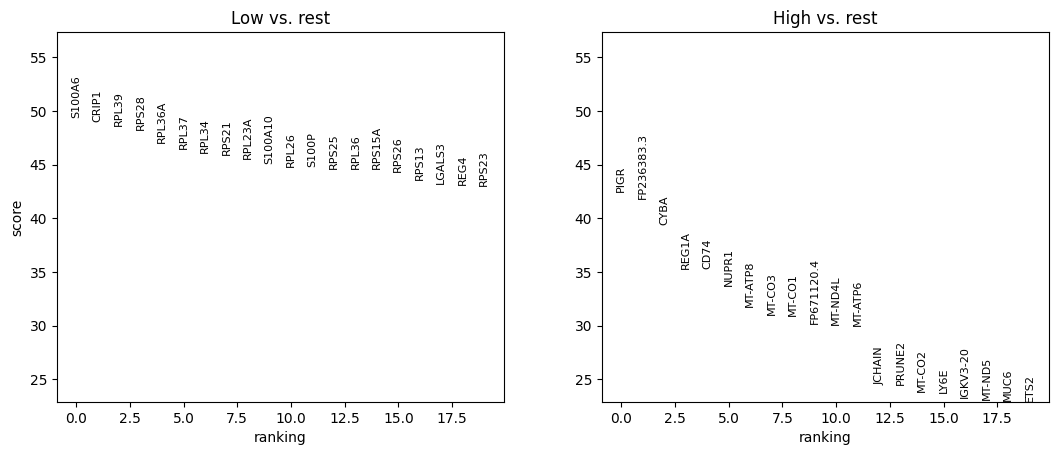

In [337]:
sc.tl.rank_genes_groups(adata_epi_chen_tumor_copy, groupby='MSI_class_crude', method='wilcoxon')
sc.pl.rank_genes_groups(adata_epi_chen_tumor_copy, groupby='MSI_class_crude',)

<Axes: xlabel='PatientID', ylabel='AvgSTRDiff'>

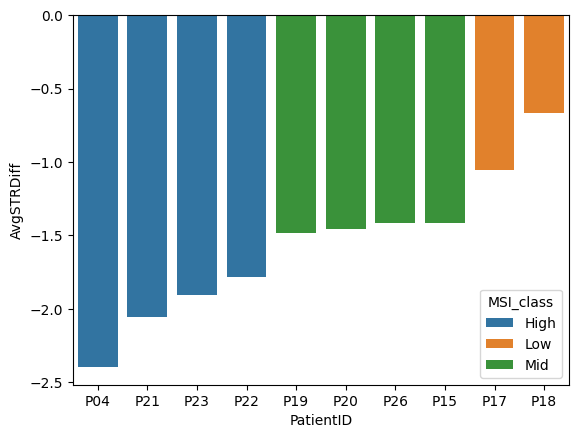

In [104]:
sns.barplot(data=adata_epi_chen_tumor.obs, x='PatientID', y='AvgSTRDiff', errorbar=None, order=list(dict_PatientID_to_MSIintensityClass.keys()), hue='MSI_class')

In [ ]:
# ~ 100 minutes
sc.tl.rank_genes_groups(adata_epi_chen_tumor, groupby='MSI_class', method='wilcoxon')

DEG_Summary = list()
for MSI_class in ['Low', 'Mid', 'High']:
    for idx, gene in enumerate(adata_epi_chen_tumor.uns['rank_genes_groups']['names'][MSI_class]):
        pvals_adj = adata_epi_chen_tumor.uns['rank_genes_groups']['pvals_adj'][MSI_class][idx]
        lfc = adata_epi_chen_tumor.uns['rank_genes_groups']['logfoldchanges'][MSI_class][idx]
        
        gene_idx = list(adata_epi_chen_tumor.var.index).index(gene)
        ExpressionArray = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['MSI_class']==MSI_class].X.T[gene_idx].toarray()
        
        DEG_Summary.append( [MSI_class, gene, pvals_adj, lfc, np.mean(ExpressionArray), np.std(ExpressionArray)] )

DEG_Summary = pd.DataFrame(DEG_Summary, columns=['MSI_class', 'gene', 'pvals_adj', 'lfc', 'avgExpression', 'stdExpression'])
DEG_Summary.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/DEG_by_MSIclass.tsv', sep='\t', index=False)

In [122]:
DEG_Summary = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/DEG_by_MSIclass.tsv', sep='\t',)

candidateDriverGenes = list()
import scipy.stats
for gene, edf in DEG_Summary.groupby('gene'):
    if min(edf['pvals_adj'])>0.05: continue 
    # if max(edf['avgExpression']< 0.5): continue
    # if max(edf['stdExpression']> 0.8): continue
    
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    try:
        bool_pos_cor = bool((dict_MSI_class_to_avgExpression['High']/dict_MSI_class_to_avgExpression['Mid']>=1) and (dict_MSI_class_to_avgExpression['Mid']/dict_MSI_class_to_avgExpression['Low']>=1))
        bool_neg_cor = bool((dict_MSI_class_to_avgExpression['Low']/dict_MSI_class_to_avgExpression['Mid']>=1) and (dict_MSI_class_to_avgExpression['Mid']/dict_MSI_class_to_avgExpression['High']>=1))
        if bool_pos_cor==False and bool_neg_cor==False:
            continue
    except ZeroDivisionError: pass 
    
    if (dict_MSI_class_to_avgExpression['Low'] < dict_MSI_class_to_avgExpression['Mid'] < dict_MSI_class_to_avgExpression['High']) or (dict_MSI_class_to_avgExpression['Low'] > dict_MSI_class_to_avgExpression['Mid'] > dict_MSI_class_to_avgExpression['High']):
        dict_MSI_class_to_lfc = { tup.MSI_class : tup.lfc for tup in edf.itertuples() }
        if (dict_MSI_class_to_lfc['Low'] < dict_MSI_class_to_lfc['Mid'] < dict_MSI_class_to_lfc['High']) or (dict_MSI_class_to_lfc['Low'] > dict_MSI_class_to_lfc['Mid'] > dict_MSI_class_to_lfc['High']):
            candidateDriverGenes.append( gene )
        else:
            pass 
    else:
        pass
    
DEG_Summary_filtered = DEG_Summary[(DEG_Summary['gene'].isin(candidateDriverGenes))].copy()
candidateDriverGenes = list()
for gene, edf in DEG_Summary_filtered.groupby('gene'):
    dict_MSI_class_to_avgExpression = { tup.MSI_class : tup.avgExpression for tup in edf.itertuples() }
    r, pval = scipy.stats.pearsonr( [1,2,3], [dict_MSI_class_to_avgExpression['Low'], dict_MSI_class_to_avgExpression['Mid'], dict_MSI_class_to_avgExpression['High']] )
    candidateDriverGenes.append( [gene, r, pval] )
candidateDriverGenes = pd.DataFrame(candidateDriverGenes, columns=['gene', 'r', 'pval'])
candidateDriverGenes.shape

(3537, 3)

In [123]:
candidateDriverGenes.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/SelectedDriverGenes.tsv', sep='\t', index=False)

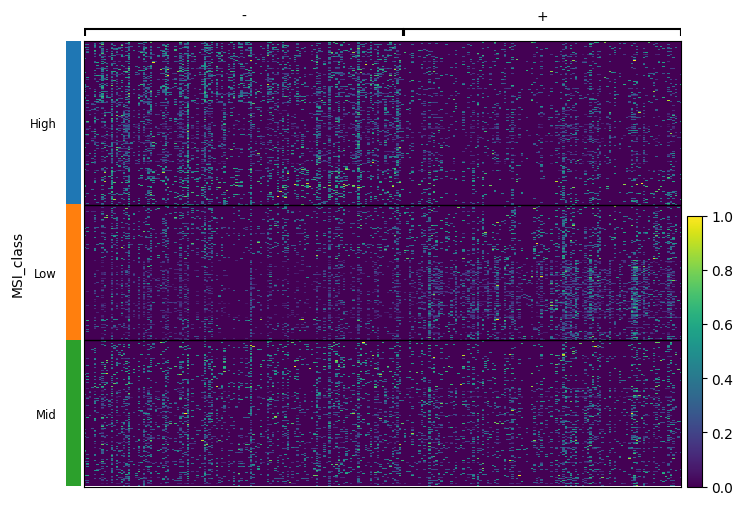

In [60]:
sc.pl.heatmap(adata_epi_chen_tumor, 
              var_names={ '-' : candidateDriverGenes[(candidateDriverGenes['pval']<=0.05) & (candidateDriverGenes['r']>=0.9)]['gene'], 
                         '+' : candidateDriverGenes[(candidateDriverGenes['pval']<=0.05) & (candidateDriverGenes['r']<=-0.9)]['gene'] }, 
              groupby='MSI_class', 
              standard_scale='var', 
            #   cmap='Blues',
              )

### Evaluate candidate genes derived from each dataset

In [343]:
chen_MSI_crude_DEGs = pd.DataFrame(adata_epi_chen_tumor_copy.uns['rank_genes_groups']['names'])
joanito_MSI_crude_DEGs = pd.DataFrame(adata_epi_joanito_tumor_copy.uns['rank_genes_groups']['names'])

In [350]:
chen_set = set(chen_MSI_crude_DEGs['Low'].head(500))
joanito_set = set(joanito_MSI_crude_DEGs['Low'].head(500))

MSI_L_intersecting_genes = chen_set.intersection(joanito_set)

chen_set = set(chen_MSI_crude_DEGs['High'].head(500))
joanito_set = set(joanito_MSI_crude_DEGs['High'].head(500))

MSI_H_intersecting_genes = chen_set.intersection(joanito_set)

In [362]:
sc.tl.score_genes(adata_epi_chen_tumor_copy, MSI_L_intersecting_genes, score_name='Intersecting_MSI_L')
sc.tl.score_genes(adata_epi_chen_tumor_copy, MSI_H_intersecting_genes, score_name='Intersecting_MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor_copy, MSI_L_intersecting_genes, score_name='Intersecting_MSI_L')
sc.tl.score_genes(adata_epi_joanito_tumor_copy, MSI_H_intersecting_genes, score_name='Intersecting_MSI_H')

sc.tl.score_genes(adata_epi_chen_tumor_copy, chen_set, score_name='Chen_MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor_copy, chen_set, score_name='Chen_MSI_H')

       'HIST1H2BJ', 'IGLV1-47', 'IGHV3-7', 'HIST1H2AG',
       ...
       'IGKV3-11', 'IGKV4-1', 'HLA-DRB5', 'IGHV3-23', 'REG1B', 'TEX14',
       'IGKV1-17', 'GRIN2B', 'MUC6', 'CASP1'],
      dtype='object', length=110)


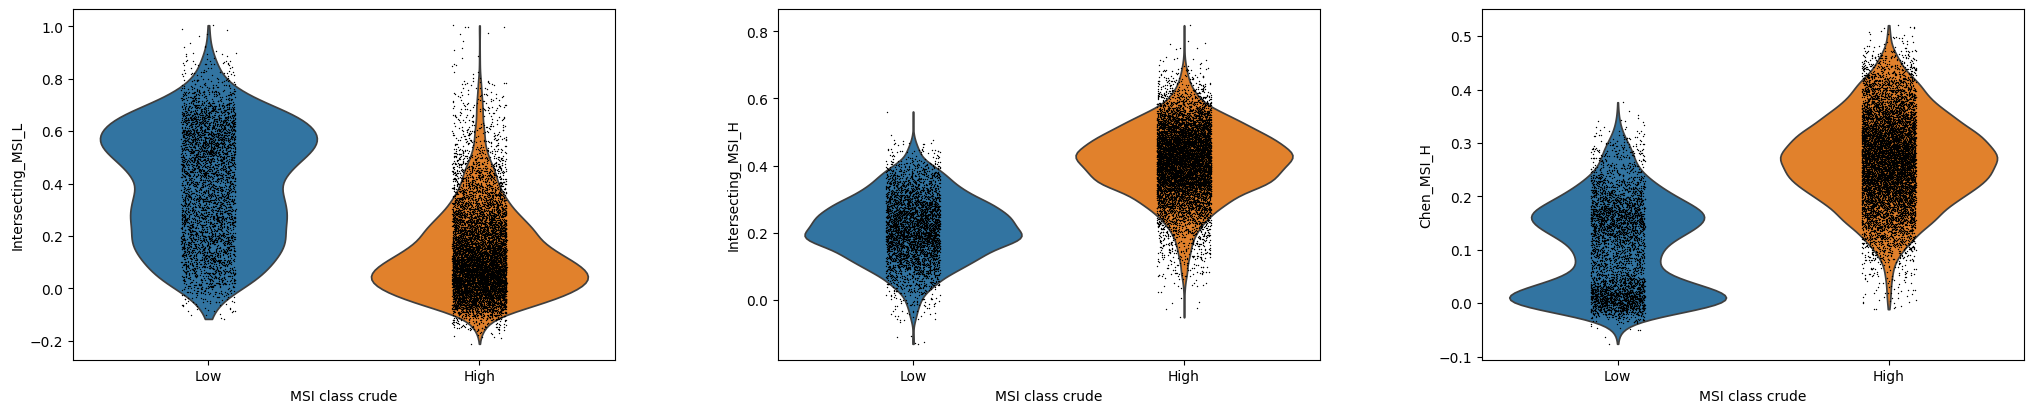

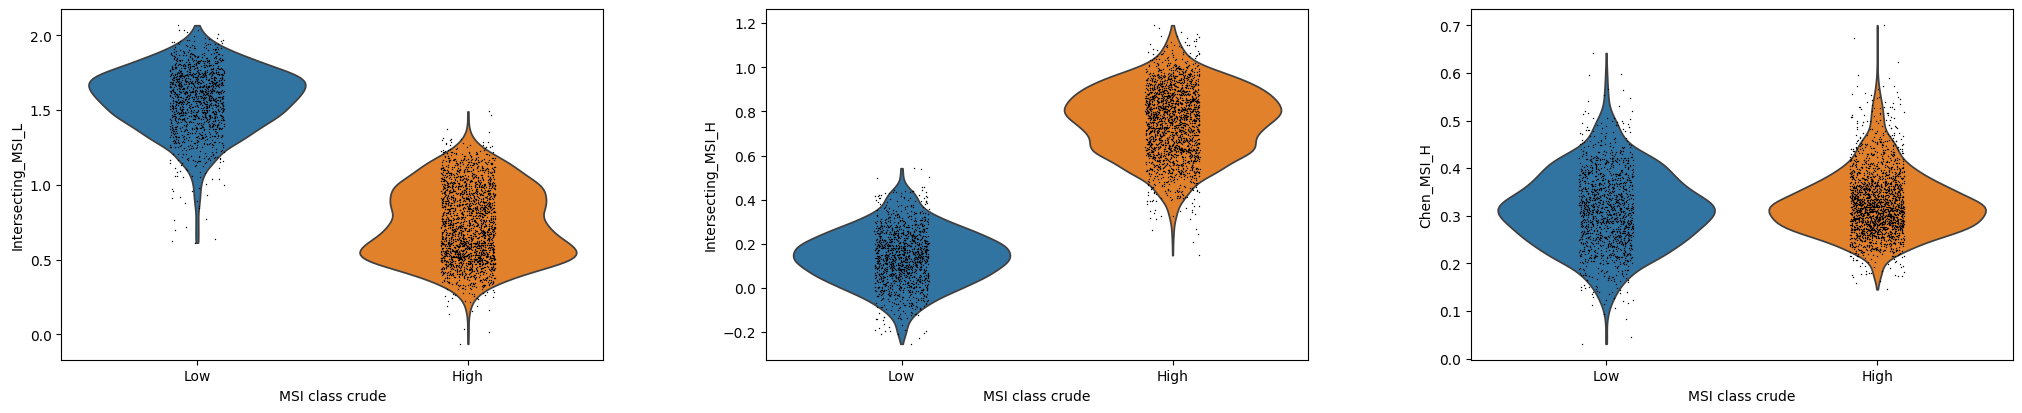

In [363]:
sc.pl.violin(adata_epi_chen_tumor_copy, keys=['Intersecting_MSI_L', 'Intersecting_MSI_H', 'Chen_MSI_H'], groupby='MSI_class_crude')
sc.pl.violin(adata_epi_joanito_tumor_copy, keys=['Intersecting_MSI_L', 'Intersecting_MSI_H', 'Chen_MSI_H'], groupby='MSI_class_crude')

In [281]:
candidateDriverGenes_chen       = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/SelectedDriverGenes.tsv', sep='\t',)
candidateDriverGenes_joanito    = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SelectedDriverGenes.tsv', sep='\t',)

In [282]:
pval_threshold = 0.1
r_threshold = 0.9
candidateDriverGenes_chen = candidateDriverGenes_chen[(candidateDriverGenes_chen['pval']<=pval_threshold) & ((candidateDriverGenes_chen['r']>=r_threshold) | (candidateDriverGenes_chen['r']<=-r_threshold))].copy()
candidateDriverGenes_joanito = candidateDriverGenes_joanito[(candidateDriverGenes_joanito['pval']<=pval_threshold) & ((candidateDriverGenes_joanito['r']>=r_threshold) | (candidateDriverGenes_joanito['r']<=-r_threshold))].copy()

intersectingGenes = set(candidateDriverGenes_chen['gene']).intersection(set(candidateDriverGenes_joanito['gene']))
len(candidateDriverGenes_chen), len(candidateDriverGenes_joanito), len(intersectingGenes)

(880, 1334, 90)

gene         r      pval
12         ABCE1 -0.999746  0.014346
17          ABI2 -0.988283  0.097549
30    AC006460.2 -0.999916  0.008246
34    AC007952.4  1.000000  0.000043
37    AC008771.1 -0.993474  0.072772
...          ...       ...       ...
3509      ZNF526  0.996553  0.052877
3519      ZNF721 -0.997649  0.043666
3521      ZNF771  0.994040  0.069537
3534      ZSWIM4 -0.997281  0.046957
3536      ZWILCH -0.989069  0.094216

[880 rows x 3 columns]

In [283]:
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['r']>=r_threshold)]['gene'], score_name='Chen_MSI_H')
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['r']<=-r_threshold)]['gene'], score_name='Chen_MSI_L')

sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['r']>=r_threshold)]['gene'], score_name='Chen_MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['r']<=-r_threshold)]['gene'], score_name='Chen_MSI_L')

In [284]:
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_joanito[(candidateDriverGenes_joanito['r']>=r_threshold)]['gene'], score_name='Joanito_MSI_H')
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_joanito[(candidateDriverGenes_joanito['r']<=-r_threshold)]['gene'], score_name='Joanito_MSI_L')

sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes_joanito[(candidateDriverGenes_joanito['r']>=r_threshold)]['gene'], score_name='Joanito_MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes_joanito[(candidateDriverGenes_joanito['r']<=-r_threshold)]['gene'], score_name='Joanito_MSI_L')

In [285]:
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['gene'].isin(intersectingGenes)) & (candidateDriverGenes['pval']<=pval_threshold) & (candidateDriverGenes_chen['r']>=r_threshold)]['gene'], score_name='Intersecting_MSI_H')
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['gene'].isin(intersectingGenes)) & (candidateDriverGenes['pval']<=pval_threshold) & (candidateDriverGenes_chen['r']<=-r_threshold)]['gene'], score_name='Intersecting_MSI_L')

sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['gene'].isin(intersectingGenes)) & (candidateDriverGenes['pval']<=pval_threshold) & (candidateDriverGenes_chen['r']>=r_threshold)]['gene'], score_name='Intersecting_MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['gene'].isin(intersectingGenes)) & (candidateDriverGenes['pval']<=pval_threshold) & (candidateDriverGenes_chen['r']<=-r_threshold)]['gene'], score_name='Intersecting_MSI_L')

/tmp/ipykernel_106552/713138543.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['gene'].isin(intersectingGenes)) & (candidateDriverGenes['pval']<=pval_threshold) & (candidateDriverGenes_chen['r']>=r_threshold)]['gene'], score_name='Intersecting_MSI_H')
/tmp/ipykernel_106552/713138543.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sc.tl.score_genes(adata_epi_chen_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGenes_chen['gene'].isin(intersectingGenes)) & (candidateDriverGenes['pval']<=pval_threshold) & (candidateDriverGenes_chen['r']<=-r_threshold)]['gene'], score_name='Intersecting_MSI_L')
/tmp/ipykernel_106552/713138543.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=candidateDriverGenes_chen[(candidateDriverGene

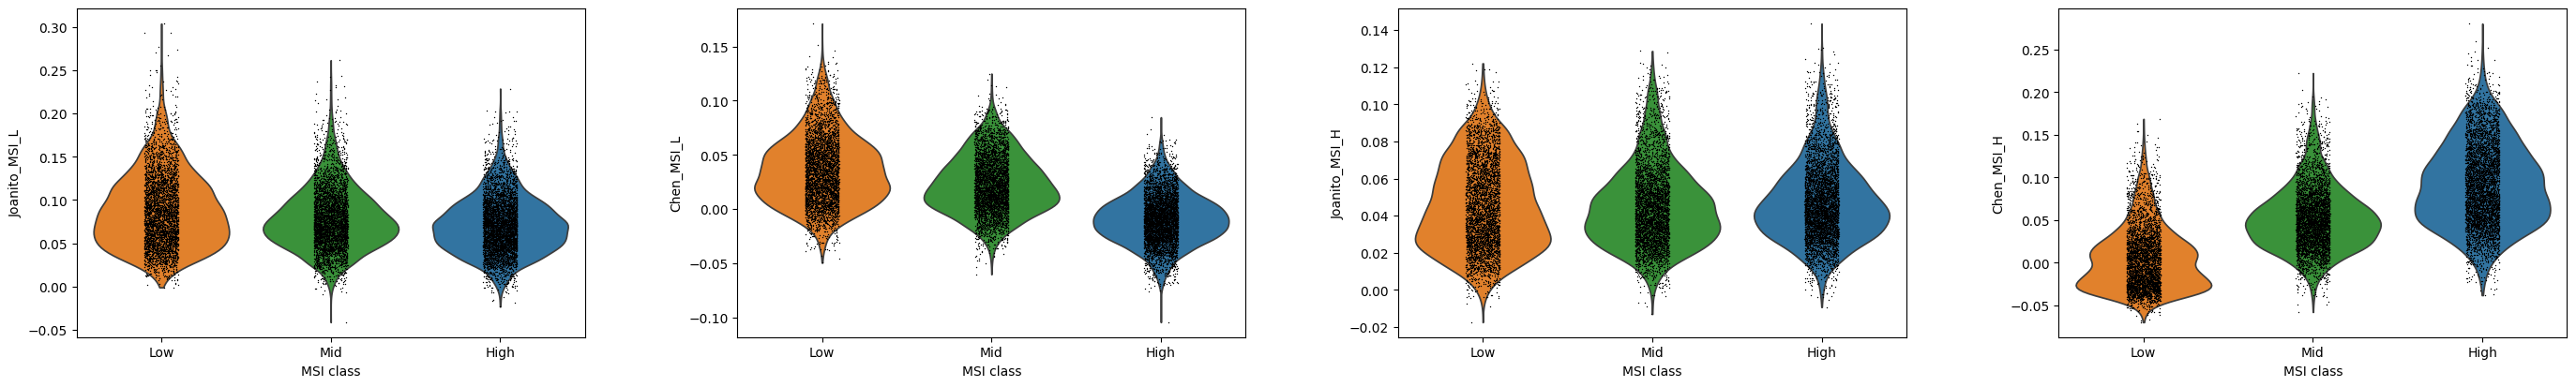

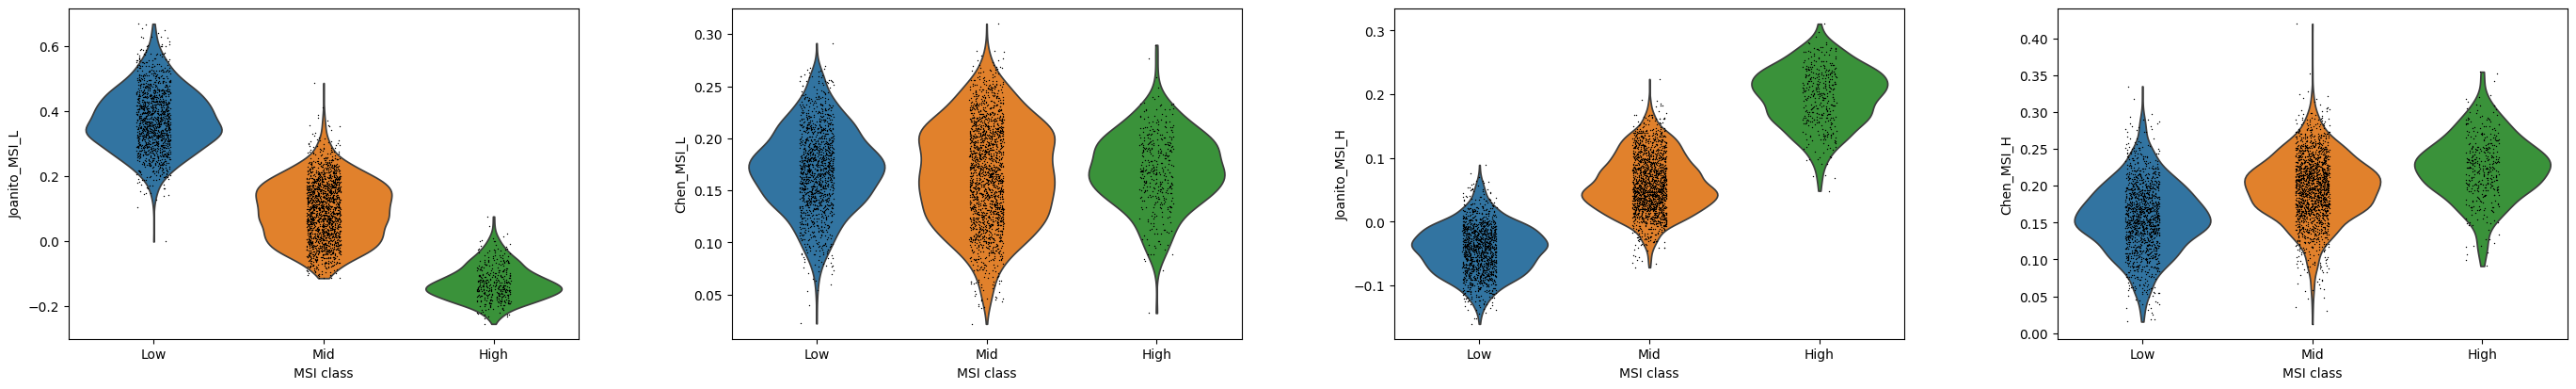

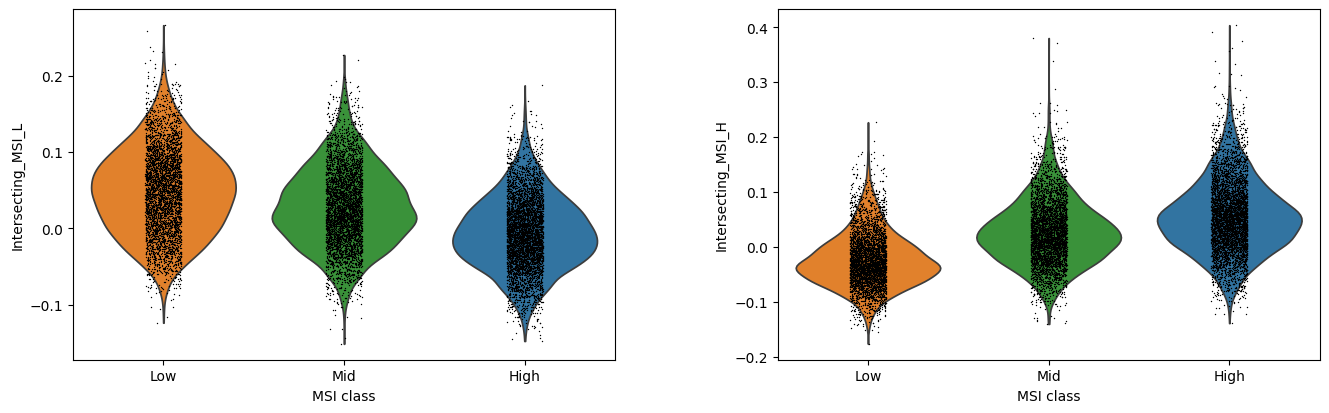

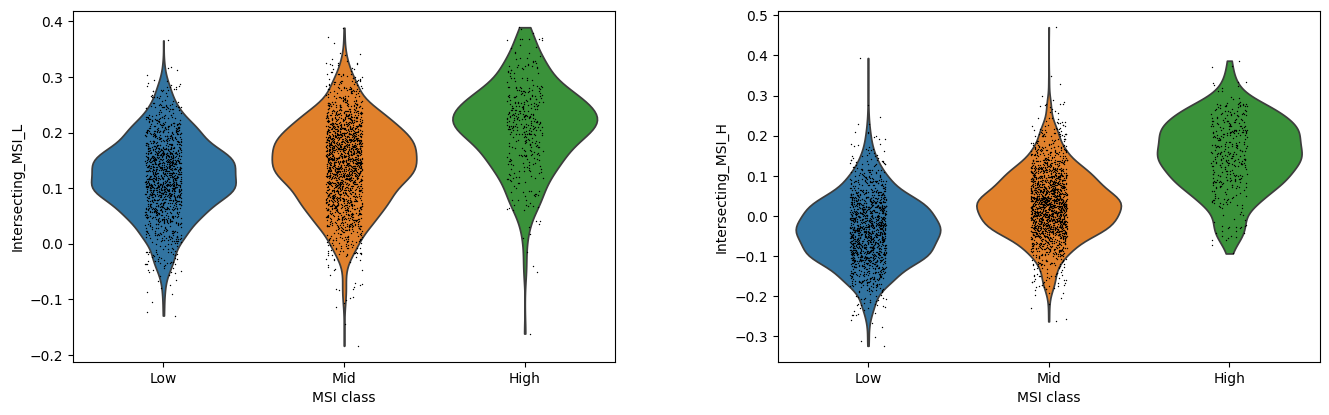

In [291]:
sc.pl.violin(adata_epi_chen_tumor, keys=['Joanito_MSI_L', 'Chen_MSI_L', 'Joanito_MSI_H', 'Chen_MSI_H'], groupby='MSI_class', order=['Low', 'Mid', 'High'])
sc.pl.violin(adata_epi_joanito_tumor, keys=['Joanito_MSI_L', 'Chen_MSI_L', 'Joanito_MSI_H', 'Chen_MSI_H'], groupby='MSI_class', order=['Low', 'Mid', 'High'])
sc.pl.violin(adata_epi_chen_tumor, keys=['Intersecting_MSI_L', 'Intersecting_MSI_H',], groupby='MSI_class', order=['Low', 'Mid', 'High'])
sc.pl.violin(adata_epi_joanito_tumor, keys=['Intersecting_MSI_L', 'Intersecting_MSI_H',], groupby='MSI_class', order=['Low', 'Mid', 'High'])

In [182]:
adata_epi_chen_tumor.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [203]:
MSI_H_chen_DEG = set(pd.DataFrame(adata_epi_chen_tumor.uns['rank_genes_groups']['names']).head(500)['High'])
MSI_L_chen_DEG = set(pd.DataFrame(adata_epi_chen_tumor.uns['rank_genes_groups']['names']).head(500)['Low'])

MSI_H_joanito_DEG = set(pd.DataFrame(adata_epi_joanito_tumor.uns['rank_genes_groups']['names']).head(500)['High'])
MSI_L_joanito_DEG = set(pd.DataFrame(adata_epi_joanito_tumor.uns['rank_genes_groups']['names']).head(500)['Low'])

len(MSI_H_chen_DEG.intersection(MSI_L_joanito_DEG)), len(MSI_H_chen_DEG.intersection(MSI_H_joanito_DEG))

(41, 47)

In [204]:
len(MSI_L_chen_DEG.intersection(MSI_L_joanito_DEG)), len(MSI_L_chen_DEG.intersection(MSI_H_joanito_DEG))

(75, 74)

In [210]:
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=MSI_H_chen_DEG.intersection(MSI_H_joanito_DEG), score_name='MSI_H')
sc.tl.score_genes(adata_epi_chen_tumor, gene_list=MSI_L_chen_DEG.intersection(MSI_L_joanito_DEG), score_name='MSI_L')

sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=MSI_H_chen_DEG.intersection(MSI_H_joanito_DEG), score_name='MSI_H')
sc.tl.score_genes(adata_epi_joanito_tumor, gene_list=MSI_L_chen_DEG.intersection(MSI_L_joanito_DEG), score_name='MSI_L')

In [220]:
for gene in MSI_L_chen_DEG.intersection(MSI_L_joanito_DEG):
    print(gene)

MDK
OST4
S100A16
LTBP4
CDKN2A
GPX2
H3F3A
S100A6
ATP5F1E
KRTCAP2
FXYD5
CRIP1
S100A10
CAPN8
CEACAM5
KRT19
UBE2H
GNG5
REG4
SERPINB5
MMP28
KDELR1
JTB
ARPC3
SNHG8
PLXDC2
TMEM147
GLG1
FUT8
COX6B1
NQO1
LGALS4
CDH17
SERF2
RABAC1
TFF3
CDK2AP2
AP3S1
AGR2
PDE4D
VSIG2
KDM5B
MIR31HG
PLEK2
MGST3
FMN1
IFITM2
MRPL52
TIMP1
UQCRB
S100P
SPIRE1
ABHD17C
GCC2
MYL12A
TM9SF3
KLF2
S100A11
DST
C12orf57
ABLIM1
S100A13
ATP5MD
LIPH
CD55
ANXA10
CD63
PRDX6
UBL5
SLC2A1
ANXA2
ANXA5
TOB1
SH3BGRL3
TSPAN1


In [ ]:
sc.pl.dotplot(adata_epi_chen_tumor, var_names=['ARGE', 'S100A6', 'AGO2', 'ANXA2'], groupby='MSI_class', standard_scale='var',
              categories_order=['Low', 'Mid', 'High'])
sc.pl.dotplot(adata_epi_joanito_tumor, var_names=['MLH1', 'S100A6', 'AGO2', 'ANXA2'], groupby='MSI_class', standard_scale='var',
              categories_order=['Low', 'Mid', 'High'])

sc.pl.dotplot(adata_epi_chen_tumor, var_names=['MLH1', 'S100A6', 'AGO2', 'ANXA2'], groupby='MSI_class',
              categories_order=['Low', 'Mid', 'High'])
sc.pl.dotplot(adata_epi_joanito_tumor, var_names=['MLH1', 'S100A6', 'AGO2', 'ANXA2'], groupby='MSI_class',
              categories_order=['Low', 'Mid', 'High'])

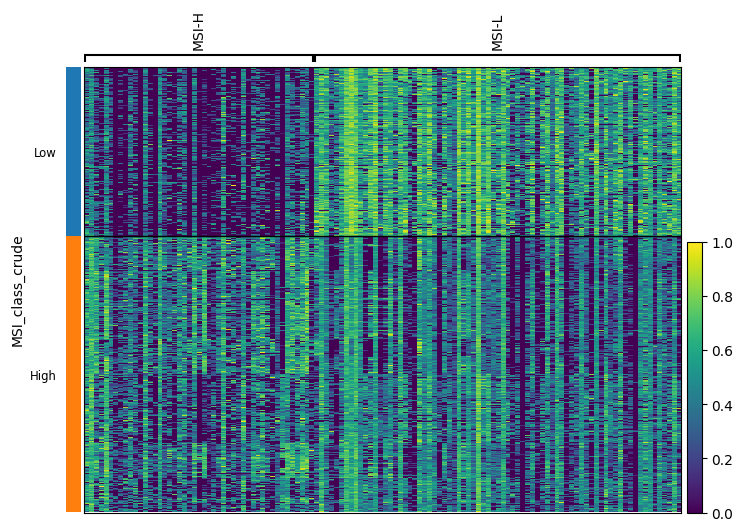

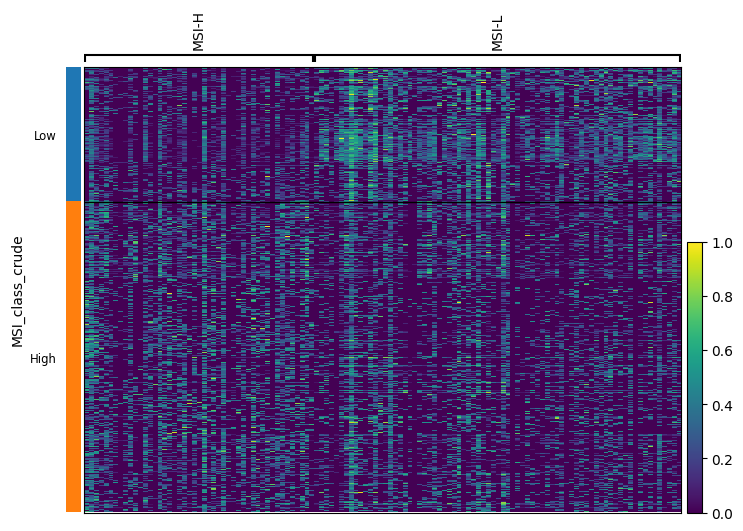

In [247]:
sc.pl.heatmap( adata_epi_joanito_tumor, var_names={'MSI-H' : MSI_H_chen_DEG.intersection(MSI_H_joanito_DEG), 
                                                'MSI-L' : MSI_L_chen_DEG.intersection(MSI_L_joanito_DEG)}, 
              groupby='MSI_class_crude', 
              standard_scale='var', )

sc.pl.heatmap( adata_epi_chen_tumor, var_names={'MSI-H' : MSI_H_chen_DEG.intersection(MSI_H_joanito_DEG), 
                                                'MSI-L' : MSI_L_chen_DEG.intersection(MSI_L_joanito_DEG)}, 
              groupby='MSI_class_crude', 
              show_gene_labels=False,
              standard_scale='var', )

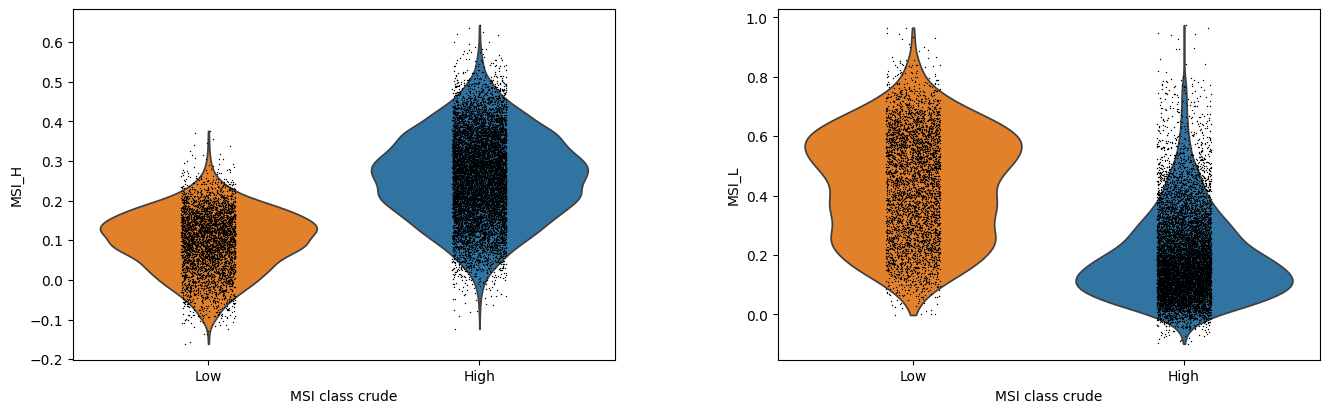

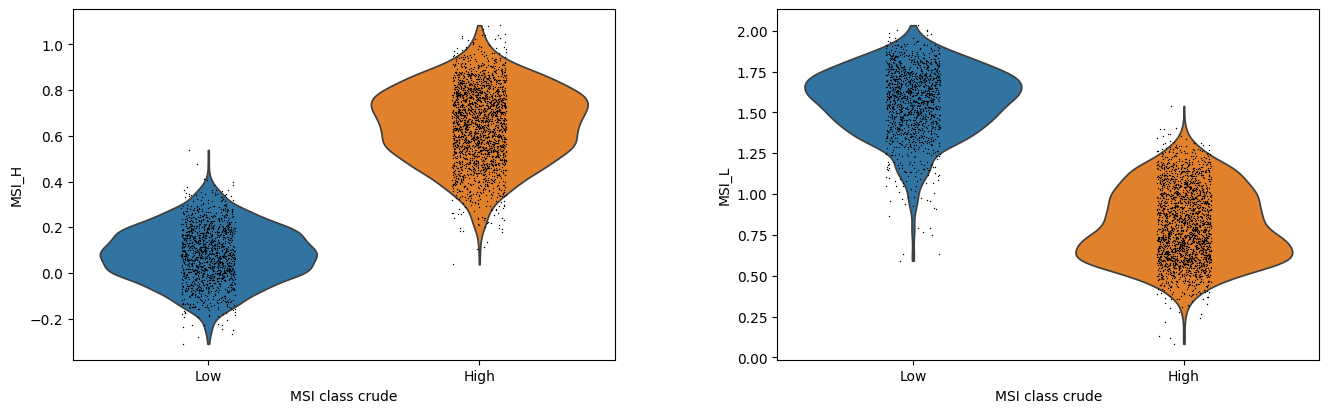

In [218]:
sc.pl.violin(adata_epi_chen_tumor, keys=['MSI_H', 'MSI_L',], groupby='MSI_class_crude', order=['Low', 'High'])
sc.pl.violin(adata_epi_joanito_tumor, keys=['MSI_H', 'MSI_L',], groupby='MSI_class_crude', order=['Low', 'High'])

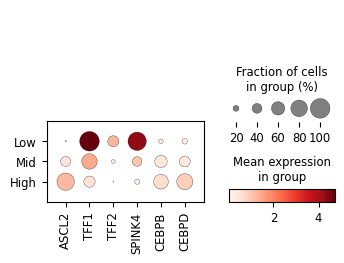

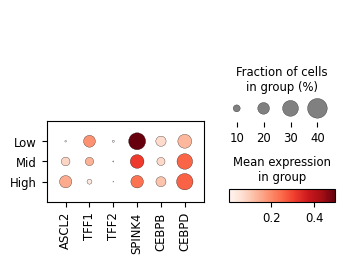

In [168]:
genesOfInterset = ['ASCL2', 'TFF1', 'TFF2', 'SPINK4', 'CEBPB', 'CEBPD']
sc.pl.dotplot(adata_epi_joanito_tumor, var_names=genesOfInterset, groupby='MSI_class', categories_order=['Low', 'Mid', 'High'])
sc.pl.dotplot(adata_epi_chen_tumor, var_names=genesOfInterset, groupby='MSI_class', categories_order=['Low', 'Mid', 'High'])

In [48]:
sig_gene_joanito = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/MSI-gene_correlation.tsv', sep='\t',)
sig_gene_chen = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/MSI-gene_correlation.tsv', sep='\t')
for gene in sig_gene_joanito[(sig_gene_joanito['pval']<=0.05) & (sig_gene_joanito['r']>=0.8)]['gene']:
    #print(gene)
    pass 

significant_genes_joanito = set(sig_gene_joanito[(sig_gene_joanito['pval']<=0.05) & (sig_gene_joanito['r']<=-0.5)]['gene'])
significant_genes_chen = set(sig_gene_chen[(sig_gene_chen['pval']<=0.05) & (sig_gene_chen['r']<=-0.5)]['gene'])
len(significant_genes_joanito), len(significant_genes_chen), len(significant_genes_joanito.intersection(significant_genes_chen))    

(953, 1427, 64)

In [53]:
sig_gene_chen

gene   P04_exp   P21_exp   P23_exp   P22_exp   P19_exp  \
0      MIR1302-2HG -0.010508 -0.005839  0.000085 -0.010508 -0.010508   
1       AL627309.1 -0.013853 -0.045171 -0.015678 -0.057471  0.006114   
2       AL627309.5 -0.068465  0.023240 -0.030262 -0.068555 -0.034522   
3       AP006222.2  0.064980 -0.034619 -0.034619 -0.034619 -0.024574   
4       AL732372.1 -0.017013 -0.012341 -0.017013 -0.017013 -0.006986   
...            ...       ...       ...       ...       ...       ...   
29763   AC136616.1 -0.013220 -0.013220 -0.013220 -0.013220 -0.003197   
29764   AC136616.2 -0.008070 -0.008070 -0.008070 -0.008070 -0.008070   
29765   AC141272.1  0.000000  0.000000  0.000000  0.000000  0.000000   
29766   AC007325.4 -0.029960  0.022638 -0.040458  0.010759 -0.051094   
29767   AC007325.2 -0.057098  0.228136 -0.111751  0.051616 -0.112330   

        P20_exp   P15_exp   P26_exp   P11_exp   P24_exp   P17_exp   P18_exp  \
0     -0.010508 -0.010508 -0.010508 -0.010508 -0.010508 -0.010508 -0.010508   
1     -0.017222 -0.047716 -0.042801  0.032984  0.035591 -0.035493  0.012697   
2     -0.064709 -0.060943  0.026386  0.107911  0.017345  0.046656  0.027016   
3     -0.034619 -0.034619 -0.034619 -0.034619 -0.034619 -0.028559 -0.026312   
4     -0.017013 -0.017013 -0.010989 -0.017013 -0.005372 -0.017013 -0.017013   
...         ...       ...       ...       ...       ...       ...       ...   
29763 -0.013220 -0.005588 -0.007199 -0.013220 -0.013220 -0.013220 -0.013220   
29764 -0.008070 -0.008070 -0.002052 -0.008070 -0.008070 -0.008070 -0.008070   
29765  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
29766 -0.035796 -0.036867 -0.020874 -0.022588  0.001381 -0.051094 -0.034453   
29767 -0.074184 -0.098929  0.019907 -0.098843 -0.004327 -0.039673 -0.008415   

              r      pval  
0      0.374263  0.230700  
1     -0.416353  0.178204  
2     -0.586963  0.044813  
3      0.494498  0.102202  
4     -0.068242  0.833099  
...         ...       ...  
29763  0.076604  0.812950  
29764  0.008900  0.978100  
29765       NaN       NaN  
29766  0.205573  0.521542  
29767  0.109790  0.734108  

[29768 rows x 15 columns]

## Cell cycle proportion → Unlikely

In [21]:
sc.tl.score_genes_cell_cycle(adata_epi_chen_tumor, S_markers, G2M_markers)
sc.tl.score_genes_cell_cycle(adata_epi_joanito_tumor, S_markers, G2M_markers)

/tmp/ipykernel_183259/1569360648.py:1: FutureWarning: The specified parameters ('s_genes', 'g2m_genes') are no longer positional. Please specify them like `s_genes=['UBR7', 'RFC2', 'RAD51', 'MCM2', 'TIPIN', 'MCM6', 'UNG', 'POLD3', 'WDR76', 'CLSPN', 'CDC45', 'CDC6', 'MSH2', 'MCM5', 'POLA1', 'MCM4', 'RAD51AP1', 'GMNN', 'RPA2', 'CASP8AP2', 'HELLS', 'E2F8', 'GINS2', 'PCNA', 'NASP', 'BRIP1', 'DSCC1', 'DTL', 'CDCA7', 'CENPU', 'ATAD2', 'CHAF1B', 'USP1', 'SLBP', 'RRM1', 'FEN1', 'RRM2', 'EXO1', 'CCNE2', 'TYMS', 'BLM', 'PRIM1', 'UHRF1']`
  sc.tl.score_genes_cell_cycle(adata_epi_chen_tumor, S_markers, G2M_markers)
/tmp/ipykernel_183259/1569360648.py:2: FutureWarning: The specified parameters ('s_genes', 'g2m_genes') are no longer positional. Please specify them like `s_genes=['UBR7', 'RFC2', 'RAD51', 'MCM2', 'TIPIN', 'MCM6', 'UNG', 'POLD3', 'WDR76', 'CLSPN', 'CDC45', 'CDC6', 'MSH2', 'MCM5', 'POLA1', 'MCM4', 'RAD51AP1', 'GMNN', 'RPA2', 'CASP8AP2', 'HELLS', 'E2F8', 'GINS2', 'PCNA', 'NASP', 'BRIP1',

### Chen et al

In [22]:
CellCycleProportion = list()
for PatientID, edf in adata_epi_chen_tumor.obs.groupby("PatientID"):
    CellCycleProportion.append( [PatientID, 
                                 len(edf[edf['phase']=='S'])/len(edf), 
                                 len(edf[edf['phase']=='G1'])/len(edf), 
                                 len(edf[edf['phase']=='G2M'])/len(edf), 
                                 len(edf), ] )
CellCycleProportion = pd.DataFrame(CellCycleProportion, columns=['PatientID', 'S_perc', 'G1_perc', 'G2_perc', 'CellCount'])

/tmp/ipykernel_183259/1004102627.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_chen_tumor.obs.groupby("PatientID"):


<Axes: xlabel='PatientID', ylabel='S_perc'>

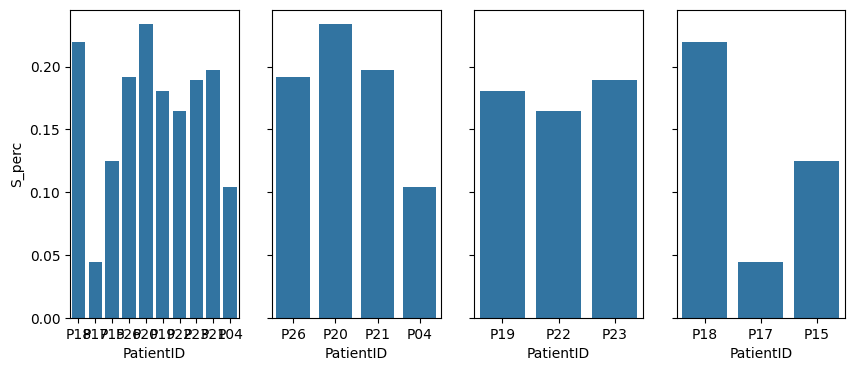

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
sns.barplot(data=CellCycleProportion, x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity, ax=axes[0])
sns.barplot(data=CellCycleProportion[CellCycleProportion['PatientID'].isin(chen_patient_order_by_MSI_intensity_AC)], 
            x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity_AC, ax=axes[1])
sns.barplot(data=CellCycleProportion[CellCycleProportion['PatientID'].isin(chen_patient_order_by_MSI_intensity_TC)], 
            x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity_TC, ax=axes[2])
sns.barplot(data=CellCycleProportion[CellCycleProportion['PatientID'].isin(chen_patient_order_by_MSI_intensity_SC)], 
            x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity_SC, ax=axes[3])

### Joanito et al

In [48]:
CellCycleProportion = list()
for PatientID, edf in adata_epi_joanito_tumor.obs.groupby("PatientID"):
    CellCycleProportion.append( [PatientID, 
                                 len(edf[edf['phase']=='S'])/len(edf), 
                                 len(edf[edf['phase']=='G1'])/len(edf), 
                                 len(edf[edf['phase']=='G2M'])/len(edf), 
                                 len(edf), ] )
CellCycleProportion = pd.DataFrame(CellCycleProportion, columns=['PatientID', 'S_perc', 'G1_perc', 'G2_perc', 'CellCount'])

/tmp/ipykernel_46852/2305206005.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_joanito_tumor.obs.groupby("PatientID"):


<Axes: xlabel='PatientID', ylabel='G2_perc'>

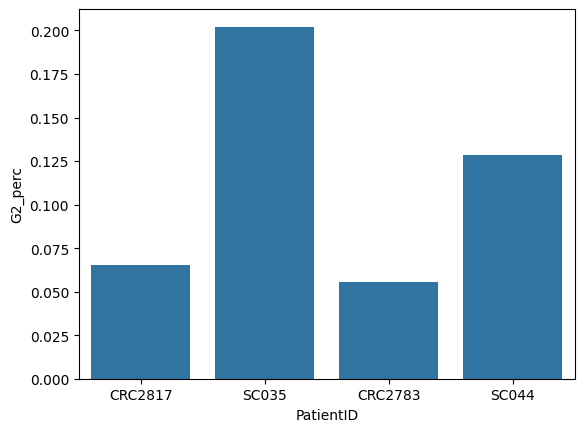

In [52]:
sns.barplot(data=CellCycleProportion, x='PatientID', y='S_perc', order=joanito_patient_order_by_MSI_intensity)

## Colon epithelial identity → Unlikely

### Chen et al

In [24]:
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='Stem']['gene'], score_name='stem_score')
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='Goblet']['gene'], score_name='goblet_score')
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='Enterocytes']['gene'], score_name='enterocyte_score')
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='E.Epithelial']['gene'], score_name='epithelial_score')

       'RP11-290L1.2', 'GYLTL1B', 'AP003774.1', 'AP000344.3', 'RP11-760H22.2',
       'ATP5G1', 'RP11-435O5.2', 'RP11-519G16.5', 'FAM84A', 'ADCK3', 'NGFRAP1',
       'RPSAP58'],
      dtype='object')
       'CTD-2589M5.4', 'RP3-340N1.5', 'FAM101A', 'MT-RNR2', 'MFSD4',
       'RP11-665N17.4', 'RP11-48O20.4', 'RP11-845C23.2', 'RP11-757F18.5',
       'RP11-92K15.3', 'GAREM'],
      dtype='object')
       'RP11-125B21.2', 'C12orf36', 'RP11-426L16.3', 'SEPP1', 'LINC00704',
       'MIR4435-1HG', 'CTC-490G23.2', 'LINC00035', 'GPR110', 'C1orf106',
       'RP11-202A13.1', 'CTB-171A8.1', 'RP11-35P15.1', 'RP11-30P6.6',
       'RP11-542M13.2'],
      dtype='object')
       'RP11-680F8.1', 'CTD-2547H18.1', 'MIR194-2', 'CTB-175P5.4',
       'RP11-30P6.6', 'AC009014.3', 'AC011298.2', 'AC106876.2', 'RP11-35P15.1',
       'C3orf83', 'RP11-187E13.1', 'RP11-465B22.8', 'RP11-542M13.2',
       'RP11-297L17.2', 'RP11-395B7.2', 'LINC00035'],
      dtype='object')


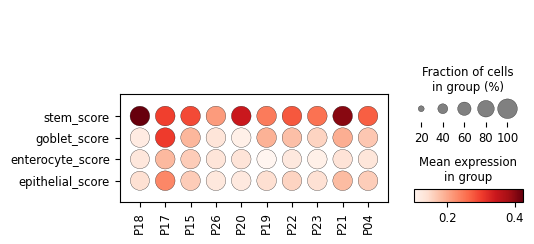

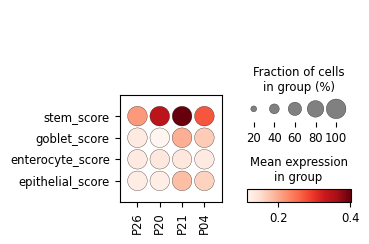

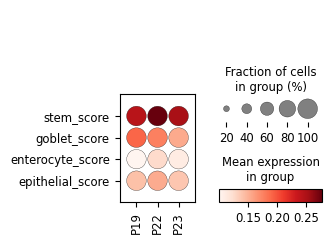

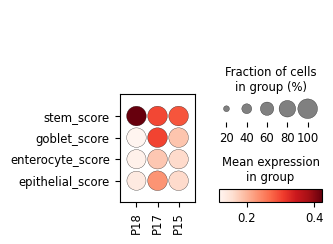

In [25]:
sc.pl.dotplot(adata_epi_chen_tumor, 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

### Joanito et al

In [26]:
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='Stem']['gene'], score_name='stem_score')
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='Goblet']['gene'], score_name='goblet_score')
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='Enterocytes']['gene'], score_name='enterocyte_score')
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='E.Epithelial']['gene'], score_name='epithelial_score')

       'RP11-290L1.2', 'GYLTL1B', 'AP003774.1', 'AP000344.3', 'RP11-760H22.2',
       'ATP5G1', 'RP11-435O5.2', 'RP11-519G16.5', 'FAM84A', 'ADCK3', 'NGFRAP1',
       'RPSAP58'],
      dtype='object')
       'CTD-2589M5.4', 'RP3-340N1.5', 'FAM101A', 'MT-RNR2', 'MFSD4',
       'RP11-665N17.4', 'RP11-48O20.4', 'RP11-845C23.2', 'RP11-757F18.5',
       'RP11-92K15.3', 'GAREM'],
      dtype='object')
       'RP11-125B21.2', 'C12orf36', 'RP11-426L16.3', 'SEPP1', 'LINC00955',
       'LINC00704', 'MIR4435-1HG', 'CTC-490G23.2', 'LINC00035', 'GPR110',
       'C1orf106', 'RP11-202A13.1', 'CTB-171A8.1', 'RP11-35P15.1',
       'RP11-30P6.6', 'RP11-542M13.2'],
      dtype='object')
       'RP11-680F8.1', 'CTD-2547H18.1', 'MIR194-2', 'CTB-175P5.4',
       'RP11-30P6.6', 'AC009014.3', 'AC011298.2', 'AC106876.2', 'RP11-35P15.1',
       'C3orf83', 'RP11-187E13.1', 'RP11-465B22.8', 'RP11-542M13.2',
       'RP11-297L17.2', 'RP11-395B7.2', 'LINC00035'],
      dtype='object')


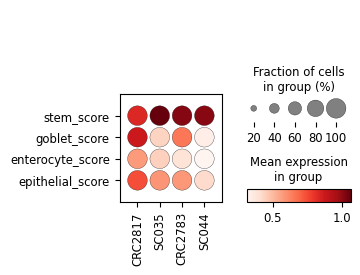

In [27]:
sc.pl.dotplot(adata_epi_joanito_tumor, 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)

## Relevant genes (MMR, Methylation, etc.) → Unlikely

In [32]:
RelevantGenes = {
#    'Methylation' : ['DNMT3A', 'DNMT3B', 'DNMT1', 'UHRF1'],
#    'Demethylation' : ['TET1', 'TET2', 'TET3'],
    'MMR' : ['MLH1', 'MSH2', 'MSH6'],
    # 'BRAF' : ['BRAF', 'KRAS', 'NRAS'],
    # 'APG' : ['HLA-A', 'HLA-B', 'HLA-C', 'TAP1', 'TAP2', 'B2M'],
    # 'Misc' : ['MUC2', 'MUC5AC', 'OLFM4'],
}

### Chen et al

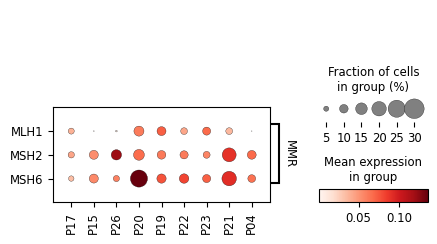

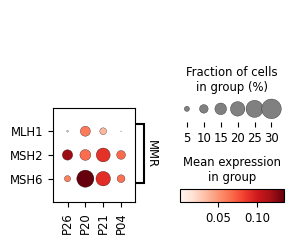

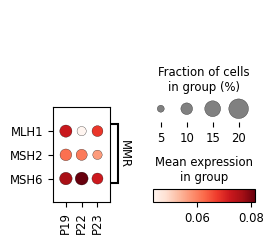

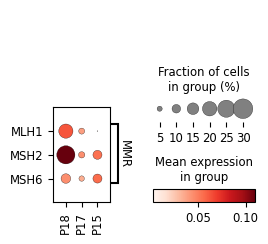

In [33]:

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_P18, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

### Joanito et al

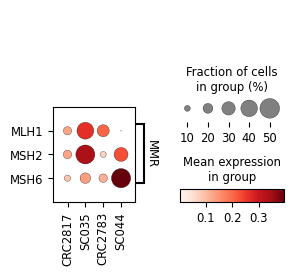

In [34]:
sc.pl.dotplot(adata_epi_joanito_tumor, 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)

## Association with tumor regression after ICI (Chen)

In [35]:
MSI_degree = list()
for PatientID, edf in adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].obs.groupby("PatientID"):
    MSI_degree.append( [PatientID, np.mean(edf['AvgSTRDiff'].dropna()), 
                        len(edf),
                        edf.iloc[0].Age, edf.iloc[0].CancerType, edf.iloc[0].TumorLocation, edf.iloc[0].TumorStage, edf.iloc[0].TumorRegressionRatio, edf.iloc[0].Response
                        ] )
MSI_degree = pd.DataFrame(MSI_degree, columns=['PatientID', 'AvgSTRDiff', 'CellCount', 
                                               'Age', 'CancerType', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'Response'])
MSI_degree.sort_values('AvgSTRDiff', ascending=False, inplace=True)

/tmp/ipykernel_183259/1781796067.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].obs.groupby("PatientID"):


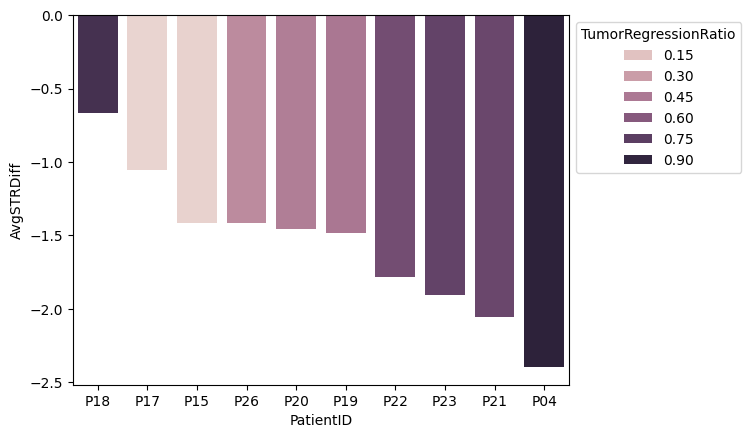

In [37]:
ax = sns.barplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & (MSI_degree['PatientID']!='aP18')], x='PatientID', y='AvgSTRDiff', 
                 hue='TumorRegressionRatio', 
                 # palette=sns.diverging_palette(220, 20, as_cmap=True),
                 )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [117]:
for TumorLoc in [ ['Ascending colon'], ['Transverse colon'], ['Sigmoid colon'], 
                 ['Ascending colon', 'Transverse colon'], ['Transverse colon', 'Sigmoid colon'], ['Ascending colon', 'Sigmoid colon'], 
                 ['Ascending colon', 'Transverse colon', 'Sigmoid colon'] ]: # MSI_degree[MSI_degree['CancerType']=='CRC']
    MSI_degree_oi = MSI_degree[(MSI_degree['CancerType']=='CRC') & (MSI_degree['TumorLocation'].isin(TumorLoc))]
    r, pval = stats.pearsonr(MSI_degree_oi['AvgSTRDiff'], MSI_degree_oi['TumorRegressionRatio'])
    print(len(TumorLoc), len(MSI_degree_oi), round(r, 3), round(100*pval, 2))
    

1 4 -0.996 0.38
1 3 -0.997 4.73
1 3 0.871 32.64
2 7 -0.978 0.01
2 6 -0.093 86.06
2 7 -0.379 40.23
3 10 -0.436 20.73


In [ ]:
""" 
1 4 -0.997 0.31		AC
1 3 -0.995 6.43		TC
1 3 0.876 32.03		SC

2 7 -0.979 0.01		AC x TC
2 6 -0.097 85.57	TC x SC
2 7 -0.384 39.52	AC x SC

3 10 -0.441 20.18	AC x TC x SC
"""

<Axes: xlabel='AvgSTRDiff', ylabel='TumorRegressionRatio'>

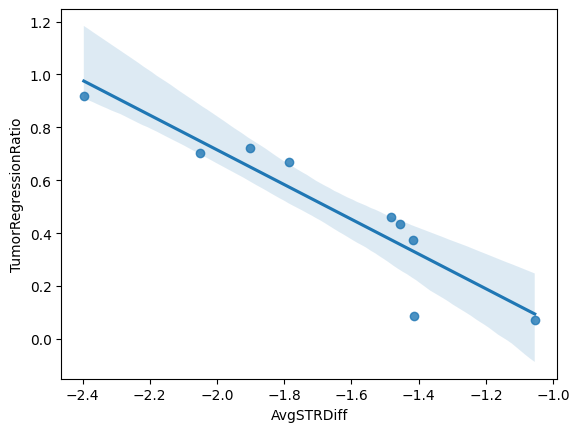

In [118]:
sns.regplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & (MSI_degree['PatientID']!='P18')], x='AvgSTRDiff', y='TumorRegressionRatio', )

## XGBoost

### Joanito et al

In [138]:
import numpy as np
import pandas as pd

minimum_loci = 10

# Features: Gene expression matrix
X = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].X if isinstance(adata_epi_joanito_tumor.X, np.ndarray) else adata_epi_joanito_tumor.X.toarray()  # Ensure dense format

# Target variable
y = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].obs['AvgSTRDiff'].values

In [139]:
X_hvg = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].X if isinstance(adata_epi_joanito_tumor.X, np.ndarray) else adata_epi_joanito_tumor.X.toarray()

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [142]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.1 MB/s eta 0:00:00a 0:00:01


In [143]:
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [144]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [145]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.13126127560921672
R² Score: 0.7622287565782708


In [146]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_hvg, y, scoring='r2', cv=5)
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {np.mean(cv_scores)}")

Cross-Validation R² Scores: [-0.54153736  0.38291907 -0.18609678  0.1039896  -0.62732391]
Mean R² Score: -0.1736098779559035


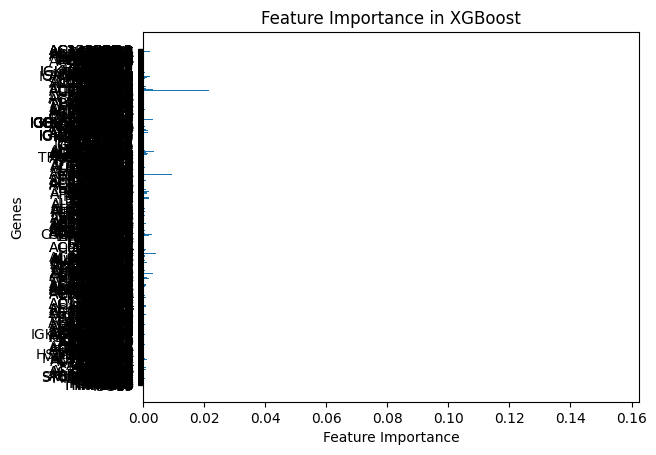

In [147]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.barh(adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].var_names, model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Genes')
plt.title('Feature Importance in XGBoost')
plt.show()

In [150]:
for idx, fi in enumerate(model.feature_importances_):
    if fi > 0.1:
        print(idx, fi)

96 0.15484539
1555 0.11057895


In [156]:
adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].var_names[96]

'S100A6'

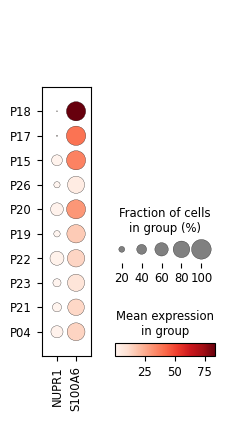

In [160]:
sc.pl.dotplot(adata_epi_chen_tumor, var_names=['NUPR1', 'S100A6'], groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity)

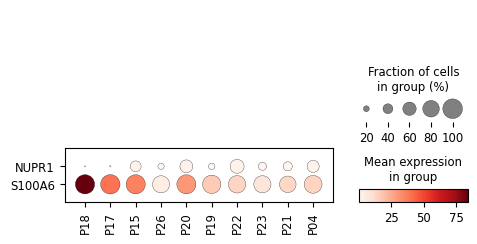

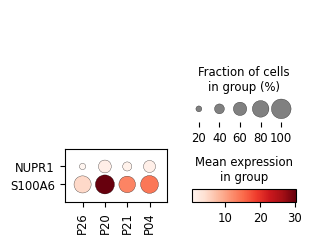

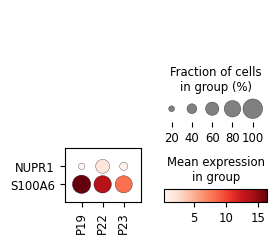

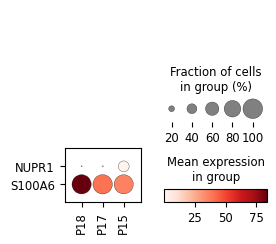

In [162]:
sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_P18, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

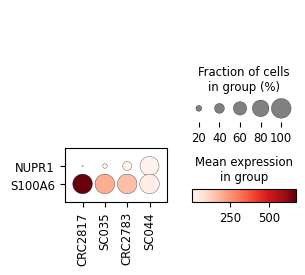

In [163]:
sc.pl.dotplot(adata_epi_joanito_tumor, 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)

### Chen et al

In [183]:
import numpy as np
import pandas as pd

minimum_loci = 10

# Features: Gene expression matrix
X = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci) & 
                         (adata_epi_chen_tumor.obs['CancerLocation']=='Ascending colon')].X if isinstance(adata_epi_chen_tumor.X, np.ndarray) else adata_epi_chen_tumor.X.toarray()  # Ensure dense format

# Target variable
y = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].obs['AvgSTRDiff'].values

KeyError: 'CancerLocation'

In [165]:
X_hvg = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].X if isinstance(adata_epi_chen_tumor.X, np.ndarray) else adata_epi_chen_tumor.X.toarray()

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [171]:
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

In [172]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [173]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.22426259469956675
R² Score: 0.5297943110241861


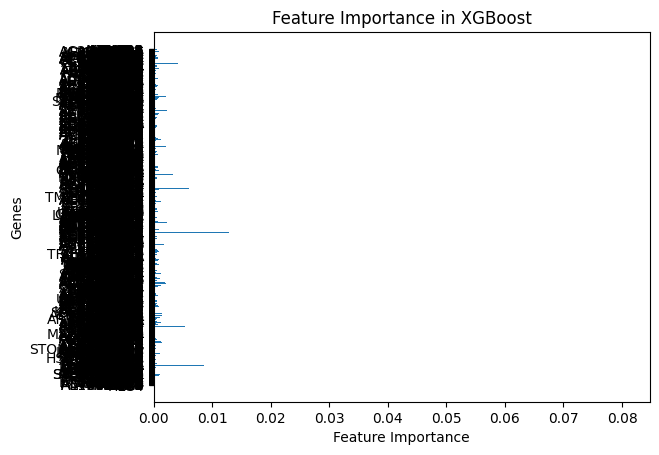

In [175]:

# Plot feature importance
plt.barh(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].var_names, model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Genes')
plt.title('Feature Importance in XGBoost')
plt.show()

In [176]:
max(model.feature_importances_)

0.08068145

In [180]:
candidate_genes = list()
for idx, fi in enumerate(model.feature_importances_):
    if fi > 0.008:
        print(idx, fi, adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].var_names[idx])
        candidate_genes.append(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].var_names[idx])

92 0.016063951 REG4
115 0.008570226 S100A6
241 0.01597191 REG1A
907 0.012797859 GRM8
1045 0.025614126 PRUNE2
1081 0.08068145 AKR1C1
1394 0.0080348225 OLFM4
1522 0.02670309 GCNT3


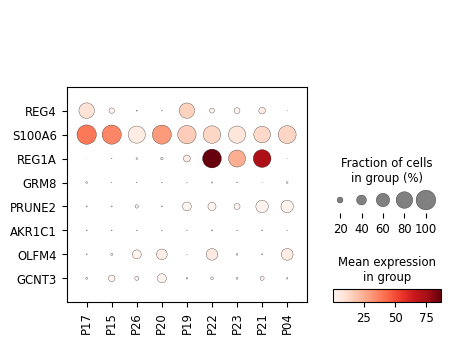

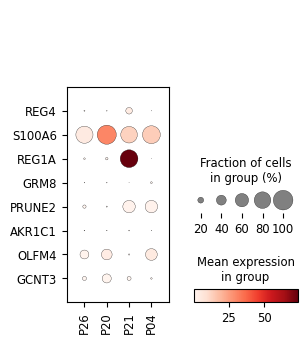

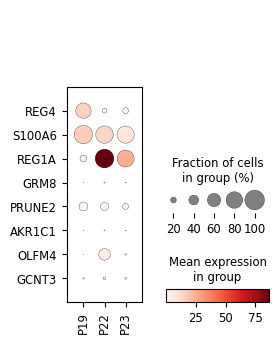

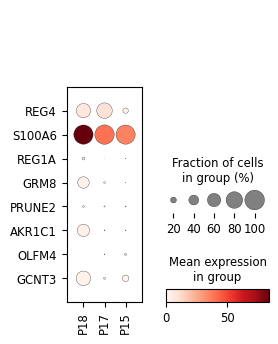

In [181]:
sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_P18, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

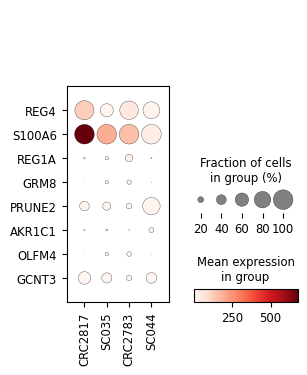

In [182]:
sc.pl.dotplot(adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['PatientID'].isin( joanito_patient_order_by_MSI_intensity )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)